Import the nesccasary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle


Loading the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv("/content/drive/MyDrive/prosperLoanData.csv")

Feature engineering: Clearing Null values,Outliers detection

In [ ]:
null_counts = data.isnull().sum()
for column, count in null_counts.items():
    print(f"Column '{column}': {count} null values")

Column 'ListingKey': 0 null values
Column 'ListingNumber': 0 null values
Column 'ListingCreationDate': 0 null values
Column 'CreditGrade': 84984 null values
Column 'Term': 0 null values
Column 'LoanStatus': 0 null values
Column 'ClosedDate': 58848 null values
Column 'BorrowerAPR': 25 null values
Column 'BorrowerRate': 0 null values
Column 'LenderYield': 0 null values
Column 'EstimatedEffectiveYield': 29084 null values
Column 'EstimatedLoss': 29084 null values
Column 'EstimatedReturn': 29084 null values
Column 'ProsperRating (numeric)': 29084 null values
Column 'ProsperRating (Alpha)': 29084 null values
Column 'ProsperScore': 29084 null values
Column 'ListingCategory (numeric)': 0 null values
Column 'BorrowerState': 5515 null values
Column 'Occupation': 3588 null values
Column 'EmploymentStatus': 2255 null values
Column 'EmploymentStatusDuration': 7625 null values
Column 'IsBorrowerHomeowner': 0 null values
Column 'CurrentlyInGroup': 0 null values
Column 'GroupKey': 100596 null values
C

Closed date column is important column as we cannot fill the null values we can only remove.

In [ ]:
data = data.dropna(subset=['ClosedDate'])

Filling the null values for the categorical columns using Mode as it is the best Aproach for the Categorical values

In [ ]:
categorical_columns = ['ListingCreationDate', 'CreditGrade', 'LoanStatus', 'BorrowerState', 'Occupation', 'EmploymentStatus',
                       'DateCreditPulled', 'FirstRecordedCreditLine', 'IncomeRange', 'LoanOriginationDate',]

# Fill null values with mode for categorical columns
for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

Checking the Numerical columns and making them the list

In [ ]:
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()

print("Numerical Features:")
print(numerical_columns)

Numerical Features:
['ListingNumber', 'Term', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperScore', 'ListingCategory (numeric)', 'EmploymentStatusDuration', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'StatedMonthlyIncome', 'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed', 'ProsperPrincipalOut

Filing the null values for Numerical columns using Median

In [ ]:
for col in numerical_columns:
    median_value = data[col].median()  # Calculate median
    data[col].fillna(median_value, inplace=True)  # Fill missing values with median

Dealing With the Datetime columns

In [ ]:
data['ClosedDate'] = pd.to_datetime(data['ClosedDate'], format='ISO8601')
data['ListingCreationDate'] = pd.to_datetime(data['ListingCreationDate'], format='ISO8601')
data['FirstRecordedCreditLine'] = pd.to_datetime(data['FirstRecordedCreditLine'], format='ISO8601')
data['LoanOriginationDate'] = pd.to_datetime(data['LoanOriginationDate'], format='ISO8601')

In [ ]:
data['DateCreditPulled'] = pd.to_datetime(data['DateCreditPulled'], format='ISO8601')

Creating the Loan tenure Column.Below is the formula used:

Loan Tenure in Months=(Year of ClosedDate−Year of LoanOriginationDate)×12+(Month of ClosedDate−Month of LoanOriginationDate)


In [ ]:
data['Loan_tenure'] = (data['ClosedDate'].dt.year - data['LoanOriginationDate'].dt.year) * 12 + (data['ClosedDate'].dt.month - data['LoanOriginationDate'].dt.month)


In [ ]:
category_counts = data['ListingCategory (numeric)'].value_counts().reset_index()

# Rename columns for clarity
category_counts.columns = ['ListingCategory (numeric)', 'Count']

# Sort the counts in descending order
category_counts_descending = category_counts.sort_values(by='Count', ascending=False)

# Sort the counts in ascending order
category_counts_ascending = category_counts.sort_values(by='Count', ascending=True)

Check the Unique values in the Loan status and Value counts of the Variables

In [ ]:
# Count the occurrences of each unique value in the LoanStatus column
loan_status_counts = data['LoanStatus'].value_counts().reset_index()

# Rename columns for clarity
loan_status_counts.columns = ['LoanStatus', 'Count']

# Display the result
print(loan_status_counts)

   LoanStatus  Count
0   Completed  38074
1  Chargedoff  11992
2   Defaulted   5018
3   Cancelled      5


The Values are in range so we convert them to average values  

In [ ]:
average_values = {
    '$25,000-49,999': 37500,  # Average of $25,000 and $49,999
    '$50,000-74,999': 62500,  # Average of $50,000 and $74,999
    'Not displayed': 0,       # Assigning 0 for 'Not displayed'
    '$100,000+': 100000,      # Value for '$100,000+'
    '$75,000-99,999': 87500,  # Average of $75,000 and $99,999
    '$1-24,999': 12500,       # Average of $1 and $24,999
    'Not employed': 0,        # Assigning 0 for 'Not employed'
    '$0': 0                   # Value for '$0'
}

# Replace income range values with manual average values
data['IncomeRange'] = data['IncomeRange'].map(average_values)

Our Loan Status Column is the Target Variable so for we have to make this as binary classification.So we use Deliquency period for converting this,if the deliquency period is above 180 it is considerd as '**defaulters**' and if its is below 180 they are **'non defaulters'**.

In [ ]:
def classify_loan_status(days_delinquent):
    if days_delinquent > 180:
        return 'Default'  # Modify to 'Charged Off' if days delinquent > 180
    else:
        return 'Non- Default'  # Modify to 'Fully Paid' if days delinquent <= 180

# Apply classification function directly to 'LoanStatus' column
data['LoanStatus'] = data['LoanCurrentDaysDelinquent'].apply(classify_loan_status)

print("Updated DataFrame with Binary Classification:")
print(data)

Updated DataFrame with Binary Classification:
                     ListingKey  ListingNumber     ListingCreationDate  \
0       1021339766868145413AB3B         193129 2007-08-26 19:09:29.263   
2       0EE9337825851032864889A          81716 2007-01-05 15:00:47.090   
11      0F1734025150298088A5F2B         213551 2007-10-09 20:28:33.640   
15      0F483544120452347F48121         577164 2012-04-10 09:14:46.297   
17      0FDF336575182398852A8DC          31540 2006-08-15 12:21:09.433   
...                         ...            ...                     ...   
113926  E34333654295683286C35C2          28121 2006-08-01 10:31:31.143   
113927  E3433419834735803891976         322787 2008-04-30 21:25:19.670   
113928  E34935176664905343E01EA         510097 2011-06-06 19:02:44.443   
113929  E3553583161337791FCB87F         830413 2013-07-06 17:40:01.657   
113935  E6EB3531504622671970D9E         539056 2011-11-14 13:18:26.597   

       CreditGrade  Term    LoanStatus ClosedDate  BorrowerAPR  B

For Multi regression model we need three target Variables as one of them is the EMI.Below is the formula for creating the EMI column:

EMI= P * r * (1+r)^n / (1+r)^n -1

Where:

𝑃
P is the principal amount (loan amount)

𝑟
r is the monthly interest rate.

𝑛
n is the tenure in months.









In [ ]:
def cal_EMI(principal, annual_rate, tenure_months):
    # Check if tenure_months is zero
    if tenure_months == 0:
        return 0
    # Calculate the monthly interest rate
    monthly_rate = annual_rate / (12 * 100)
    # Check if monthly_rate is zero to avoid division by zero
    if monthly_rate == 0:
        return principal / tenure_months
    # Calculate the EMI using the formula
    try:
        emi = principal * monthly_rate * ((1 + monthly_rate) ** tenure_months) / (((1 + monthly_rate) ** tenure_months) - 1)
    except ZeroDivisionError:
        emi = 0  # In case of any unexpected zero division, return 0 as EMI
    return emi

# Assuming df is your DataFrame and it already has the required columns
data['EMI'] = data.apply(lambda row: cal_EMI(row['LP_CustomerPrincipalPayments'], row['BorrowerRate'], row['Loan_tenure']),axis=1)

In [ ]:
data['EMI']

0         410.430378
2          86.097006
11        333.406947
15         26.249996
17        190.090495
             ...    
113926     35.745011
113927    119.346786
113928    666.877678
113929    357.457093
113935    715.992603
Name: EMI, Length: 55089, dtype: float64

Creating the eligible Loan amount column as this also the target variable:

Totalpaymentdue:

Total Payment Due=(P+(P× R/100
​
 ))×T

 Max Allowable Amount=M×12×0.30

 Eligible Loan Amount= {  p  if Total Payment Due≤Max Allowable Amount
                          
                           0 Otherwise
                       
                      


In [ ]:
# Define the functions for the calculations
def calculate_total_payment_due(principal, annual_rate, tenure_months):
    total_payment_due = (principal + (principal * annual_rate / 100)) * tenure_months
    return total_payment_due

def calculate_max_allowable_amount(monthly_income):
    max_allowable_amount = monthly_income * 12 * 0.30
    return max_allowable_amount

def calculate_eligible_loan_amount(row):
    total_payment_due = calculate_total_payment_due(row["LP_CustomerPrincipalPayments"], row["BorrowerRate"], row["Loan_tenure"])
    max_allowable_amount = calculate_max_allowable_amount(row["StatedMonthlyIncome"])

    if total_payment_due <= max_allowable_amount:
        return row["LP_CustomerPrincipalPayments"]
    else:
        return 0  # or you can return a different value indicating ineligibility

# Assuming data is your DataFrame and it already has the required columns
data["TotalPaymentDue"] = data.apply(lambda row: calculate_total_payment_due(row["LP_CustomerPrincipalPayments"], row["BorrowerRate"], row["Loan_tenure"]), axis=1)
data["MaxAllowableAmount"] = data["StatedMonthlyIncome"] * 12 * 0.30
data["EligibleLoanAmount"] = data.apply(calculate_eligible_loan_amount, axis=1)

# Describe the Eligible Loan Amount column
print(data["EligibleLoanAmount"].describe())

count    55089.000000
mean       429.862315
std       1634.443476
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      30000.000000
Name: EligibleLoanAmount, dtype: float64


Creating another iportant variable PROI(Preferred rate of intrest)

ROI (Return on Investment):

ROI
=
InterestAmount
TotalAmount
ROI=
InterestAmount/TotalAmount

PROI=Median(ROI)
​


In [ ]:
def PROI(data):
    # Calculate ROI
    data['InterestAmount'] = data['LoanOriginalAmount'] * data['BorrowerRate']
    data['TotalAmount'] = data['InterestAmount'] + data['LoanOriginalAmount']
    data['ROI'] = data['InterestAmount'] / data['TotalAmount']
    print(data['ROI'].describe())

    # Setting initial PROI to the median of ROI
    data['PROI'] = data['ROI'].median()

    # Conditions to adjust PROI
    data.loc[data['LP_CustomerPrincipalPayments'] <= 1000, 'PROI'] += 0.05
    data.loc[(data['LP_CustomerPrincipalPayments'] > 2000) & (data['LP_CustomerPrincipalPayments'] <= 10500), 'PROI'] -= 0.05
    data.loc[data['LP_CustomerPrincipalPayments'] > 10500, 'PROI'] -= 0.1
    data.loc[data['ProsperRating (Alpha)'].isin([2, 3]), 'PROI'] += 0.05
    data.loc[data['ProsperRating (Alpha)'] == 6, 'PROI'] -= 0.05
    data.loc[data['LoanOriginalAmount'] <= 2000, 'PROI'] -= 0.05
    data.loc[(data['LoanOriginalAmount'] > 19500) & (data['LoanOriginalAmount'] <= 25500), 'PROI'] += 0.05
    data.loc[data['LoanOriginalAmount'] > 25500, 'PROI'] += 0.1
    data.loc[data['LoanCurrentDaysDelinquent'] >= 50, 'PROI'] += 0.05
    data.loc[data['MonthlyLoanPayment'] <= 90, 'PROI'] -= 0.05
    data.loc[(data['MonthlyLoanPayment'] > 360) & (data['MonthlyLoanPayment'] <= 750), 'PROI'] += 0.05

    print(data['PROI'].describe())

    return data

# Apply the function to the sample data
data = PROI(data)

# Display the resulting DataFrame
data['PROI']

count    55089.000000
mean         0.163146
std          0.056440
min          0.000000
25%          0.118943
50%          0.162830
75%          0.212536
max          0.332220
Name: ROI, dtype: float64
count    55089.000000
mean         0.140029
std          0.062103
min          0.012830
25%          0.112830
50%          0.112830
75%          0.162830
max          0.362830
Name: PROI, dtype: float64


0         0.11283
2         0.11283
11        0.11283
15        0.26283
17        0.16283
           ...   
113926    0.26283
113927    0.11283
113928    0.06283
113929    0.11283
113935    0.11283
Name: PROI, Length: 55089, dtype: float64

Removing the unnessacary columns

In [ ]:
data.drop('LoanKey', axis=1, inplace=True)
data.drop('MemberKey', axis=1, inplace=True)
data.drop('ListingKey', axis=1, inplace=True)
data.drop('GroupKey', axis=1, inplace=True)
data.drop('ListingNumber', axis=1, inplace=True)
data.drop('ProsperRating (Alpha)', axis=1, inplace=True)
data.drop('LoanOriginationQuarter', axis=1, inplace=True)

Doing the Label encoding for the categorical columns

In [ ]:
label_encoder = LabelEncoder()
data['CreditGrade'] = label_encoder.fit_transform(data['CreditGrade'])
data['BorrowerState'] = label_encoder.fit_transform(data['BorrowerState'])
data['Occupation'] = label_encoder.fit_transform(data['Occupation'])
data['EmploymentStatus'] = label_encoder.fit_transform(data['EmploymentStatus'])
data['LoanStatus'] = label_encoder.fit_transform(data['LoanStatus'])

Converting the object columns to integers

In [ ]:
data['IsBorrowerHomeowner'] = data['IsBorrowerHomeowner'].astype(int)

data['CurrentlyInGroup'] = data['CurrentlyInGroup'].astype(int)

data['IncomeVerifiable'] = data['IncomeVerifiable'].astype(int)

As our data contains negative values we will find the negetive values and converting them to positives

In [ ]:
# Check if each numeric column contains any negative values
numeric_data = data.select_dtypes(include=['number'])
cols_with_negatives = numeric_data.columns[(numeric_data < 0).any()].tolist()

# Count the number of negative values in each of these columns
negative_counts = numeric_data[cols_with_negatives].lt(0).sum()

# Print the number of columns with negative values
print(f"Number of columns with negative values: {len(cols_with_negatives)}")

# Print the count of negative values in these columns
print("Count of negative values in these columns:")
print(negative_counts)

Number of columns with negative values: 13
Count of negative values in these columns:
LenderYield                       12
EstimatedEffectiveYield          190
EstimatedReturn                  195
ScorexChangeAtTimeOfListing     4826
LP_CustomerPayments                1
LP_InterestandFees                 2
LP_ServiceFees                 53657
LP_CollectionFees               6230
LP_GrossPrincipalLoss              1
LP_NetPrincipalLoss               69
Loan_tenure                        1
EMI                                1
TotalPaymentDue                    1
dtype: int64


Remove the signs from the values

In [ ]:
data['ScorexChangeAtTimeOfListing'] = data['ScorexChangeAtTimeOfListing'].abs()
data['LP_ServiceFees'] = data['LP_ServiceFees'].abs()
data['LP_CollectionFees'] = data['LP_CollectionFees'].abs()

In [ ]:
data = data[data['LP_GrossPrincipalLoss'] >= 0]
data = data[data['LP_NetPrincipalLoss'] >= 0]
data = data[data['LP_InterestandFees'] >= 0]
data = data[data['LP_CustomerPayments'] >= 0]
data = data[data['EstimatedReturn'] >= 0]
data = data[data['EstimatedEffectiveYield'] >= 0]
data = data[data['LenderYield'] >= 0]

In [ ]:
data = data[data['Loan_tenure'] >= 0]
data = data[data['EMI'] >= 0]
data = data[data['TotalPaymentDue'] >= 0]

check weather all the values are in same datatype

In [ ]:
for column in data.columns:
    print(f"Column: {column}, DataType: {data[column].dtype}")

Column: ListingCreationDate, DataType: datetime64[ns]
Column: CreditGrade, DataType: int64
Column: Term, DataType: int64
Column: LoanStatus, DataType: int64
Column: ClosedDate, DataType: datetime64[ns]
Column: BorrowerAPR, DataType: float64
Column: BorrowerRate, DataType: float64
Column: LenderYield, DataType: float64
Column: EstimatedEffectiveYield, DataType: float64
Column: EstimatedLoss, DataType: float64
Column: EstimatedReturn, DataType: float64
Column: ProsperRating (numeric), DataType: float64
Column: ProsperScore, DataType: float64
Column: ListingCategory (numeric), DataType: int64
Column: BorrowerState, DataType: int64
Column: Occupation, DataType: int64
Column: EmploymentStatus, DataType: int64
Column: EmploymentStatusDuration, DataType: float64
Column: IsBorrowerHomeowner, DataType: int64
Column: CurrentlyInGroup, DataType: int64
Column: DateCreditPulled, DataType: datetime64[ns]
Column: CreditScoreRangeLower, DataType: float64
Column: CreditScoreRangeUpper, DataType: float6

Removing the outliers from the data is nescassary as it increases the noise in the data which models have a negetive impact

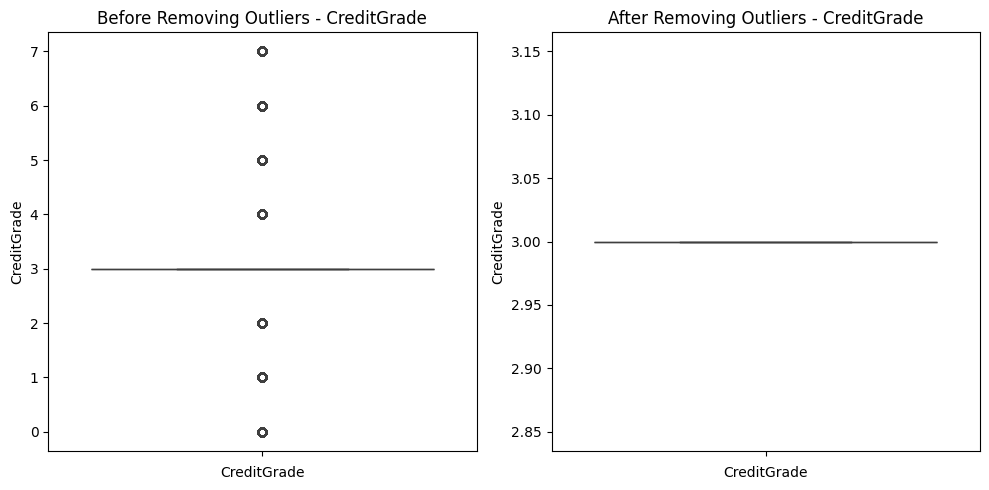

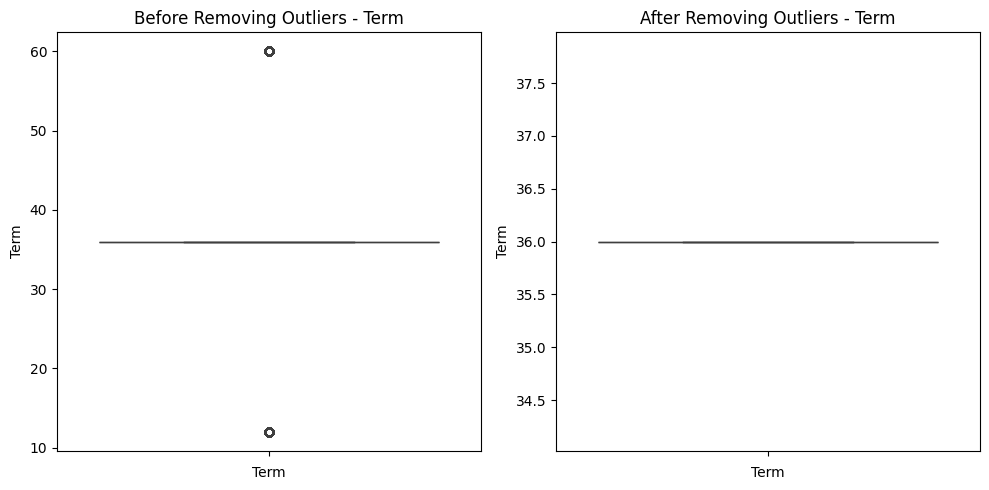

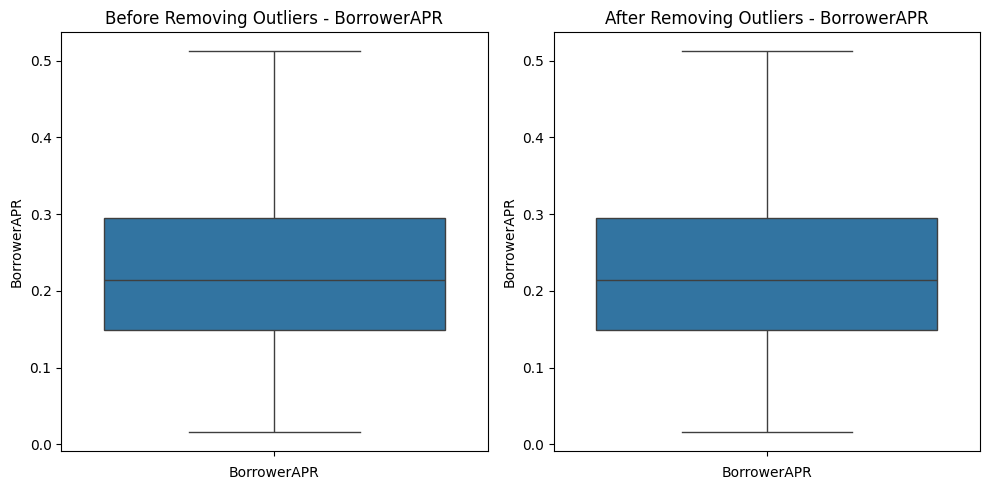

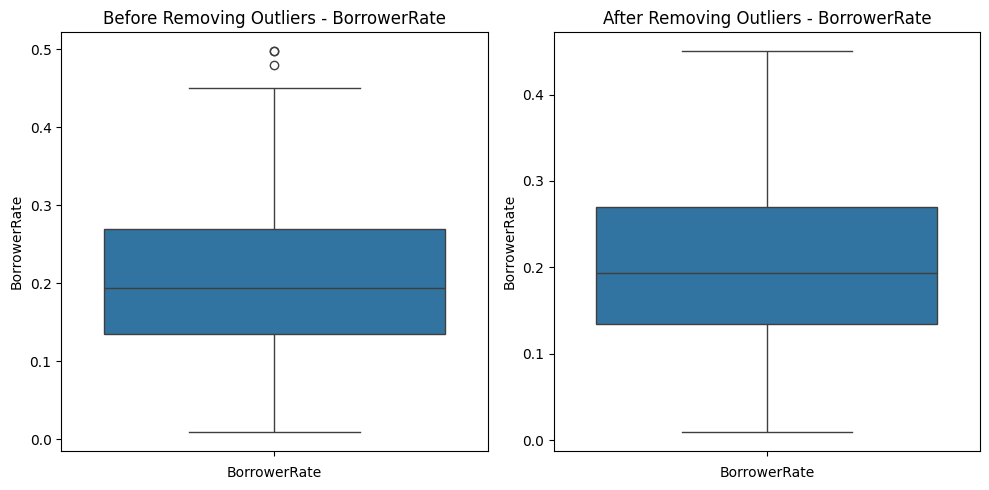

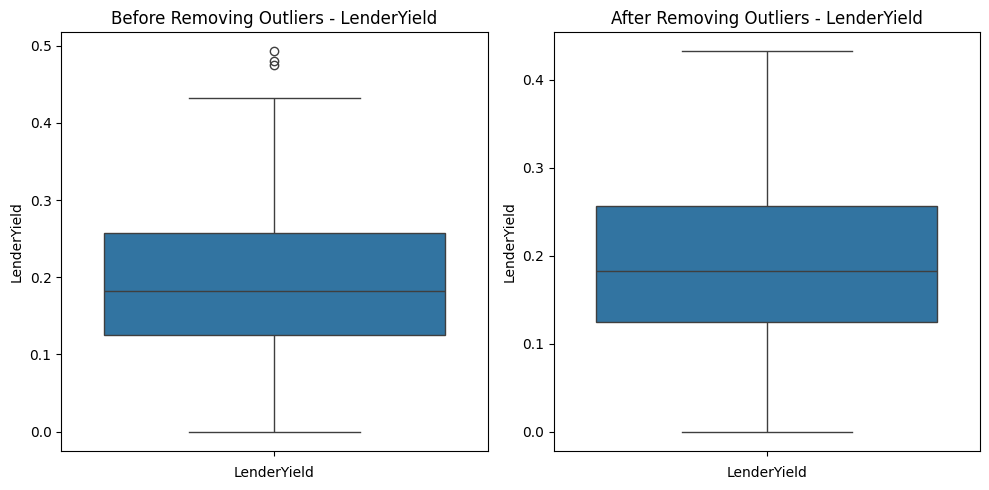

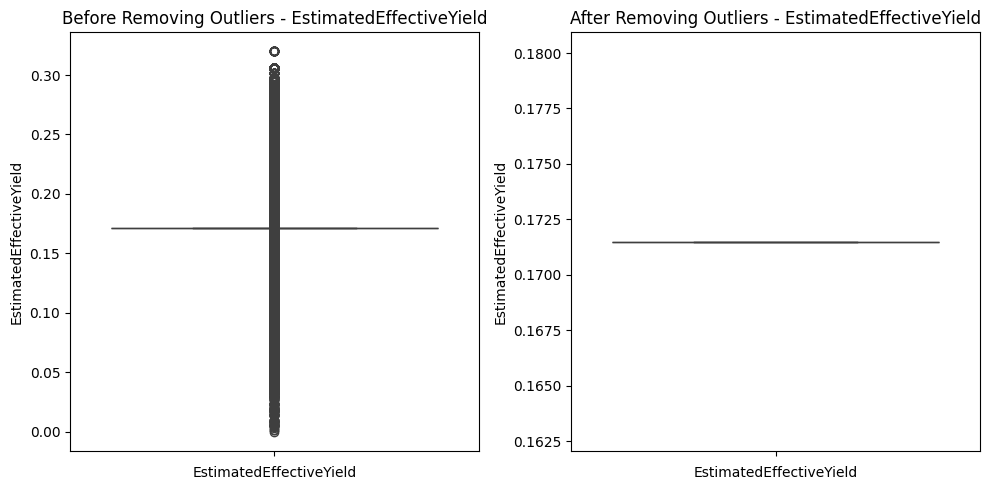

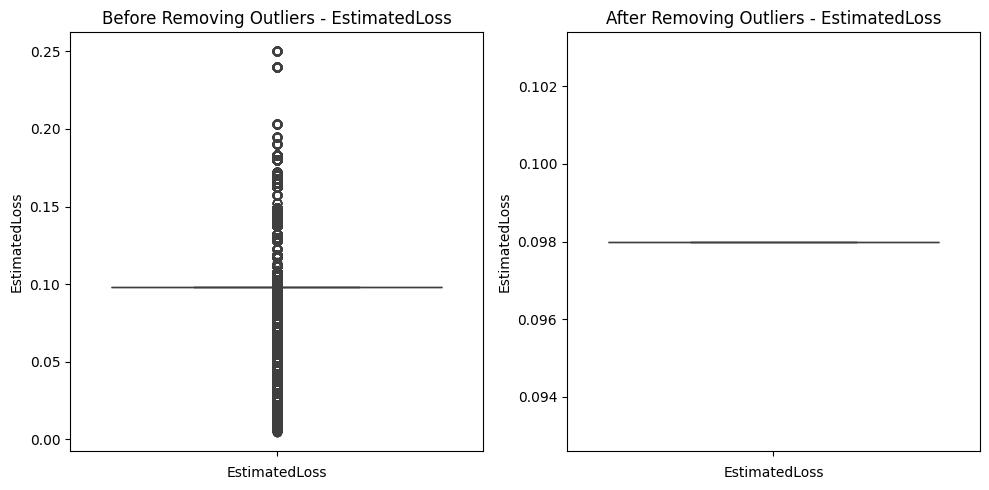

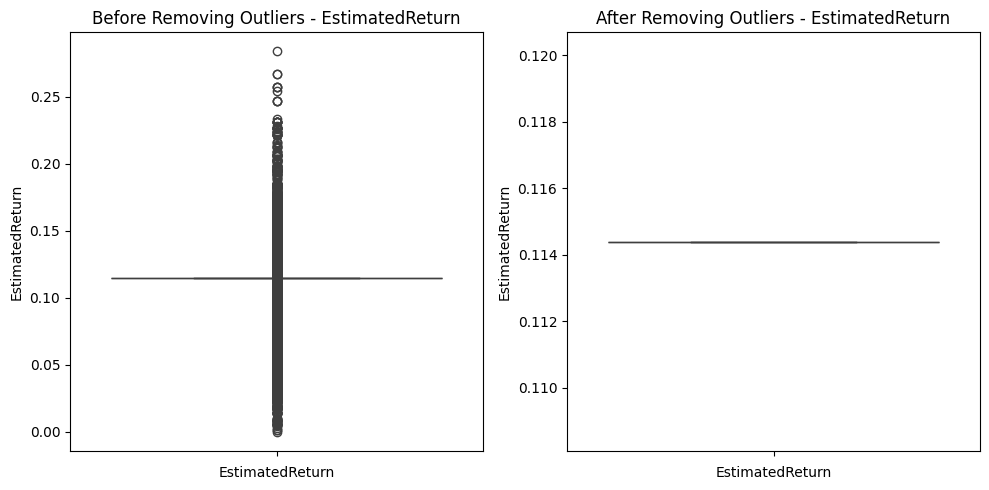

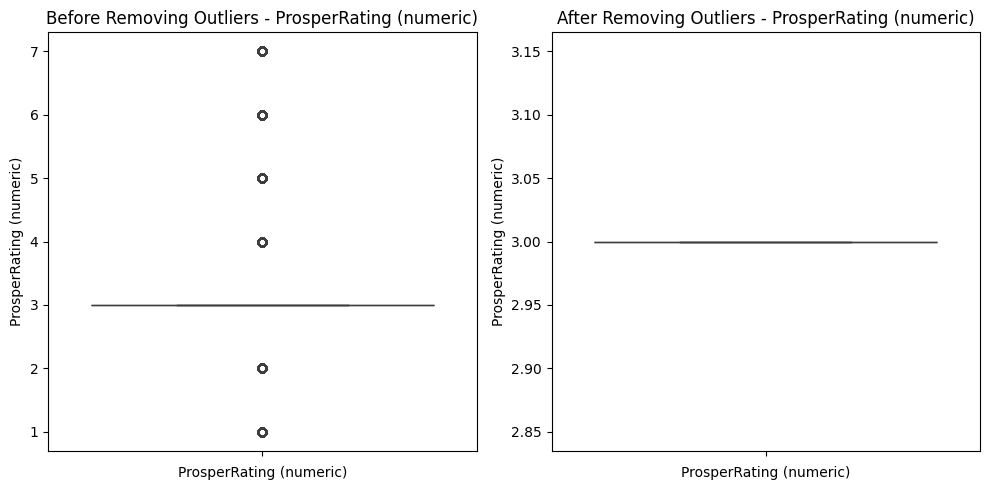

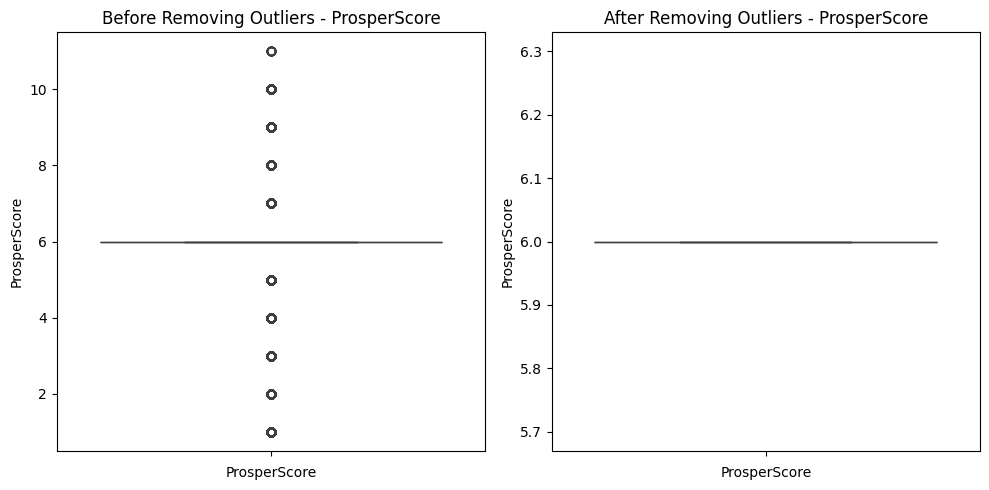

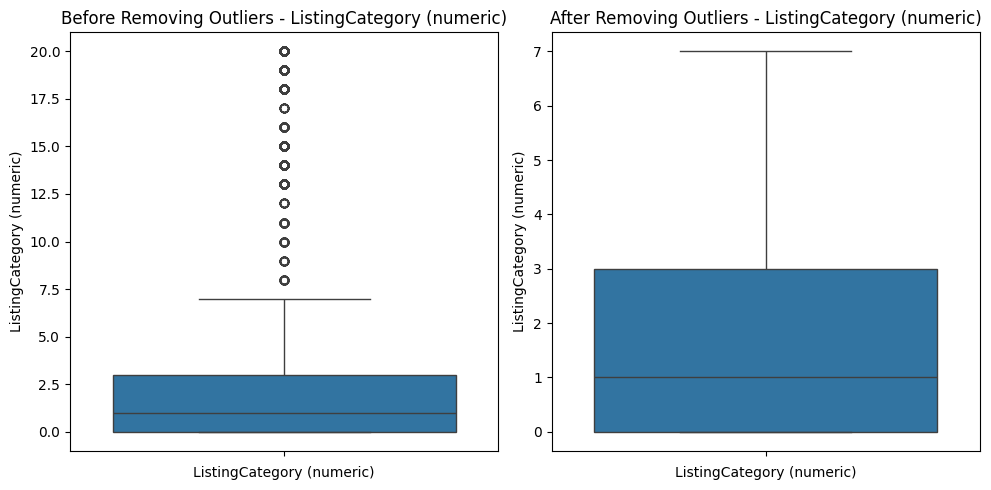

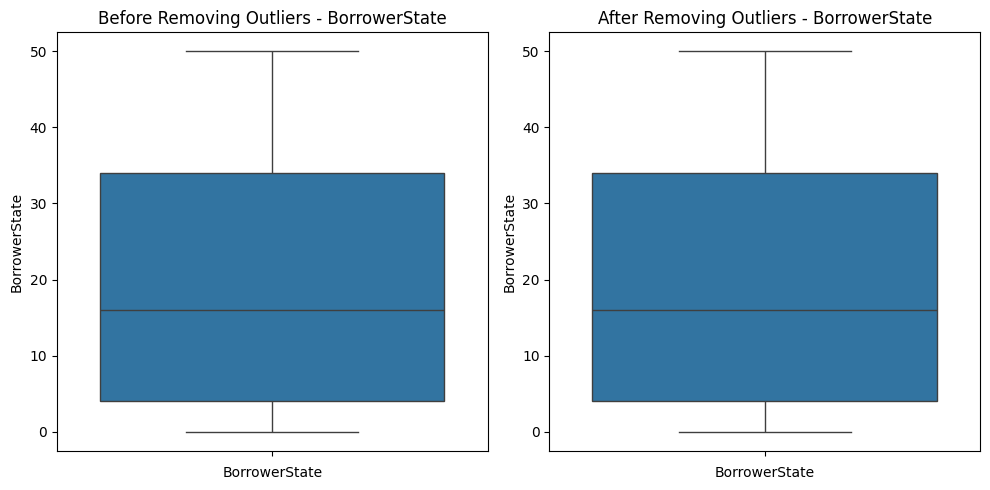

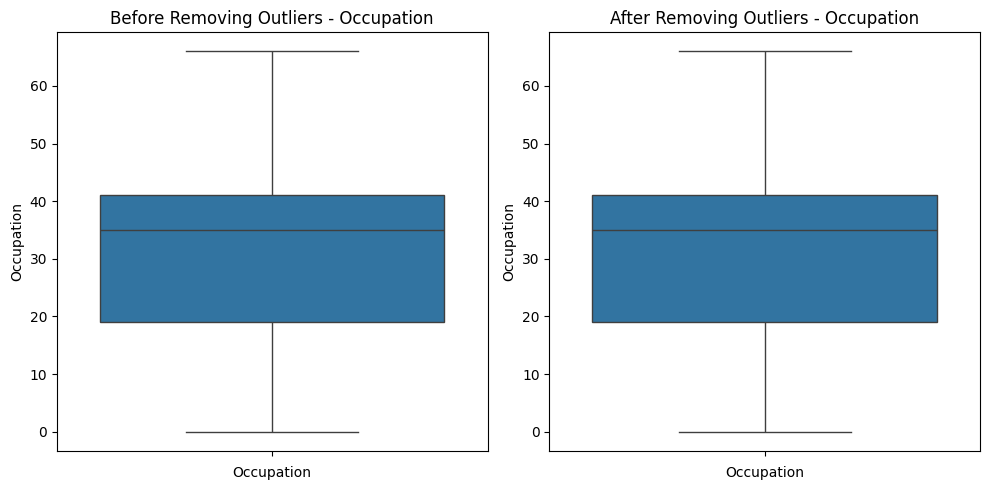

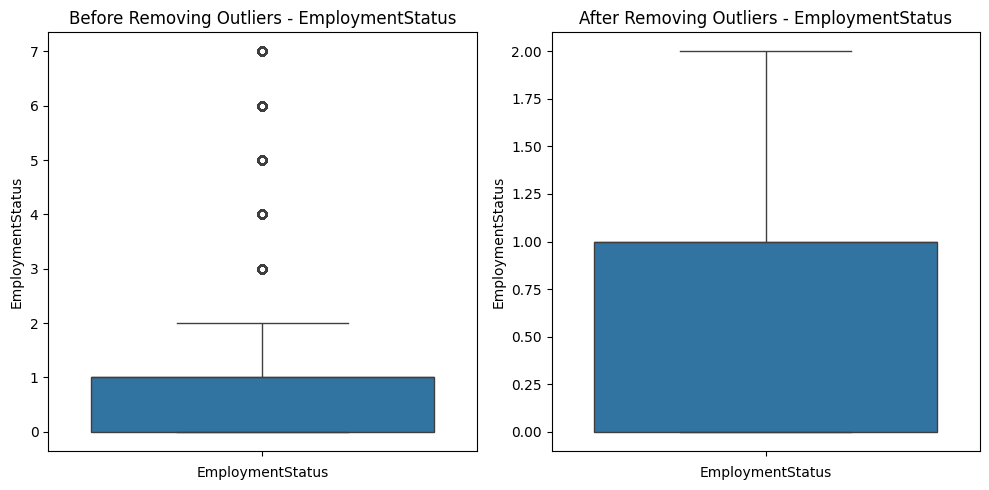

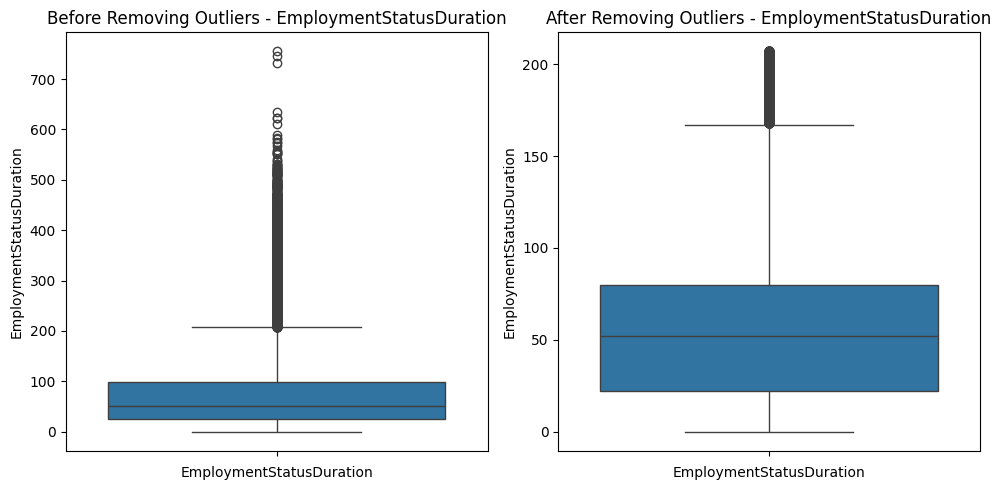

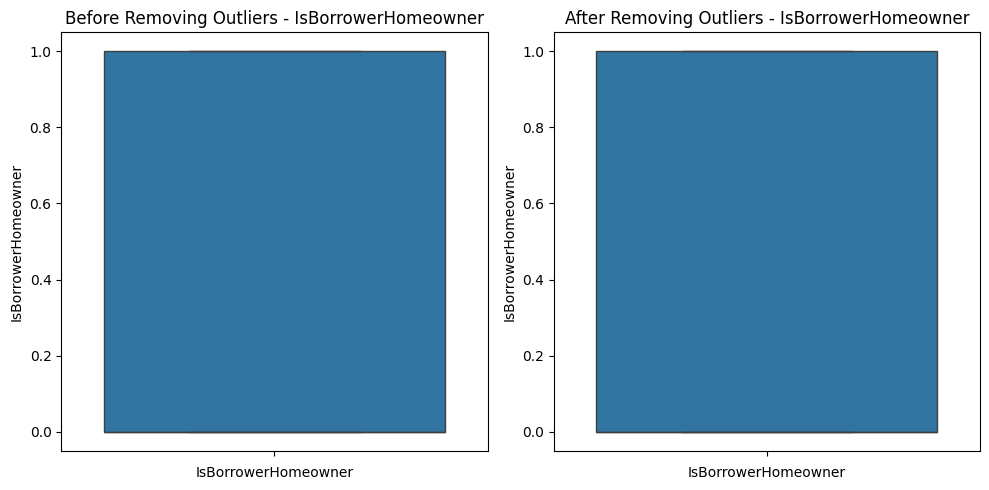

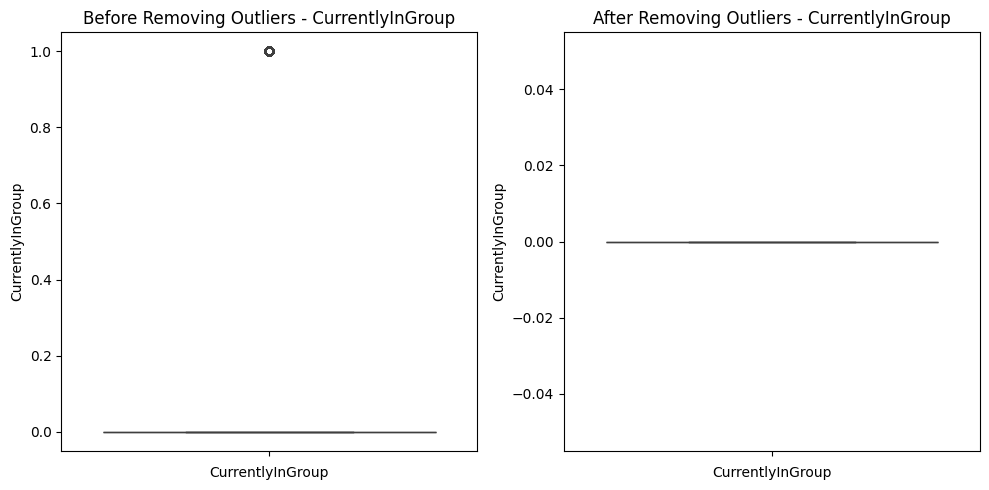

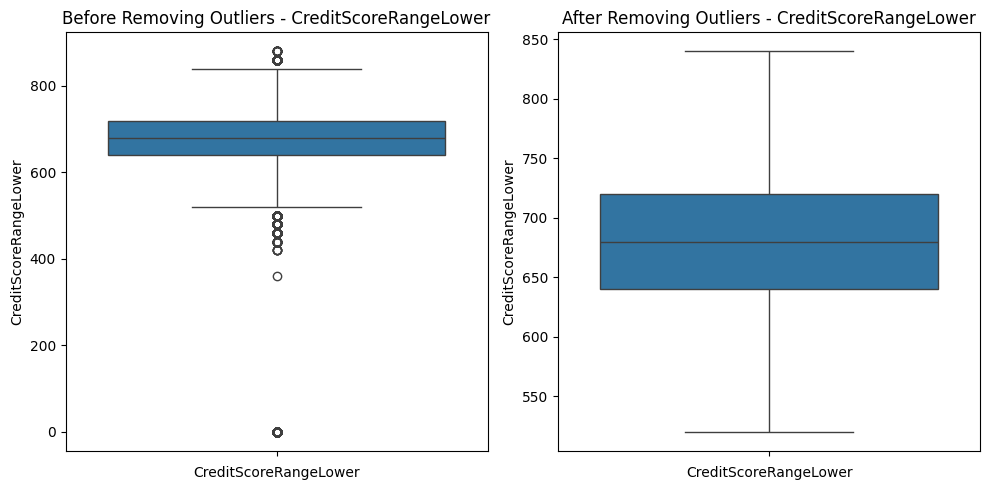

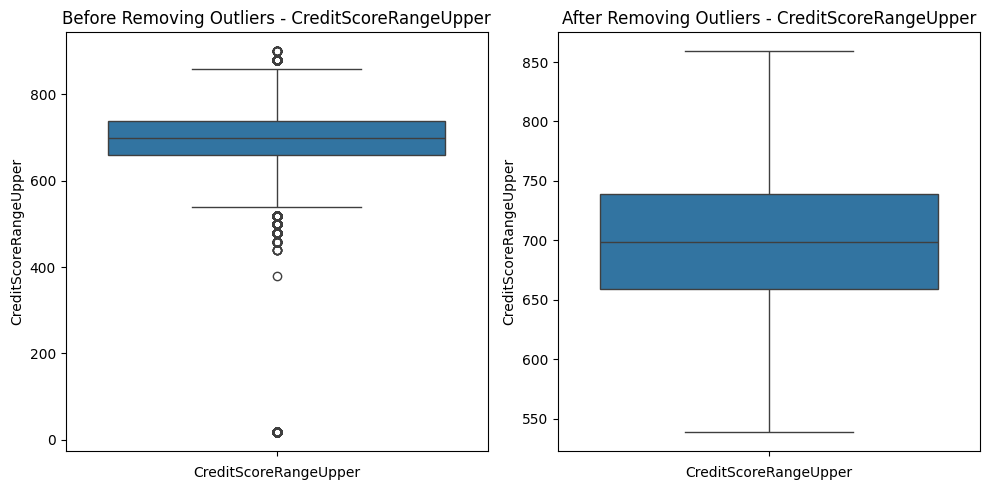

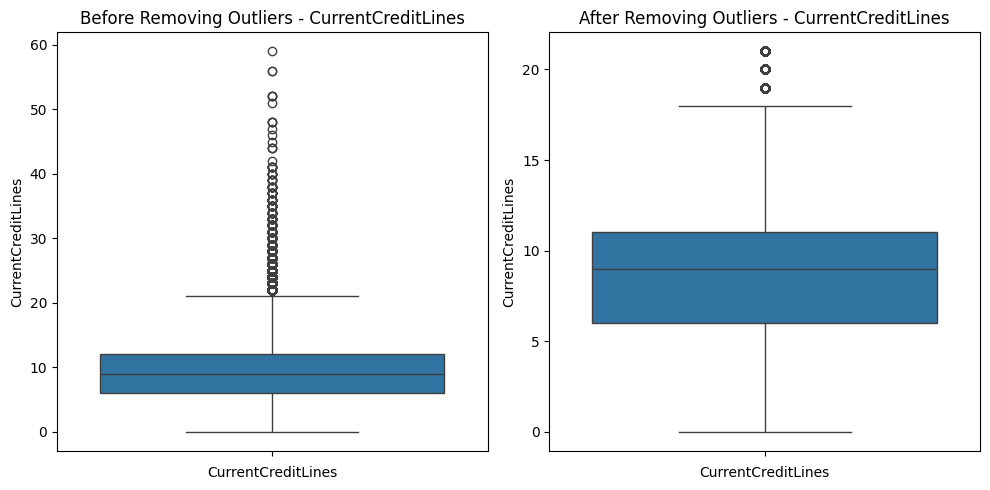

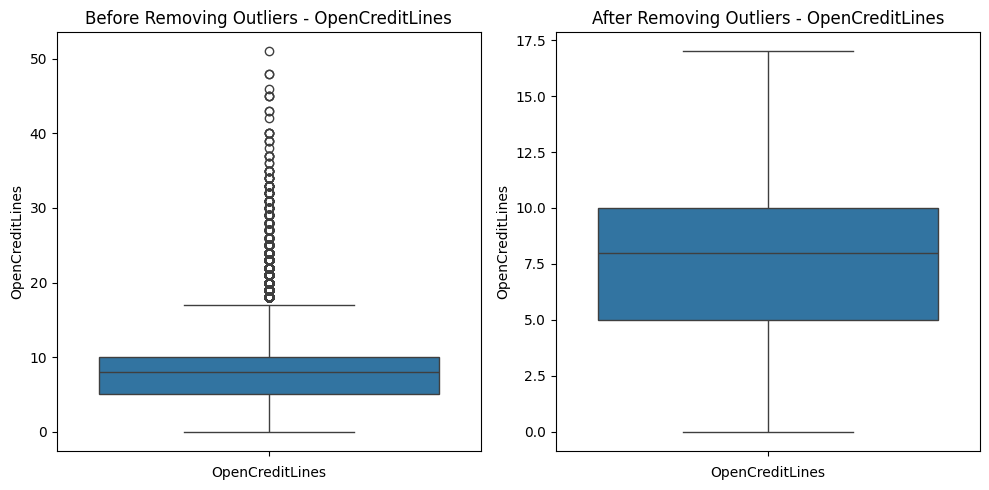

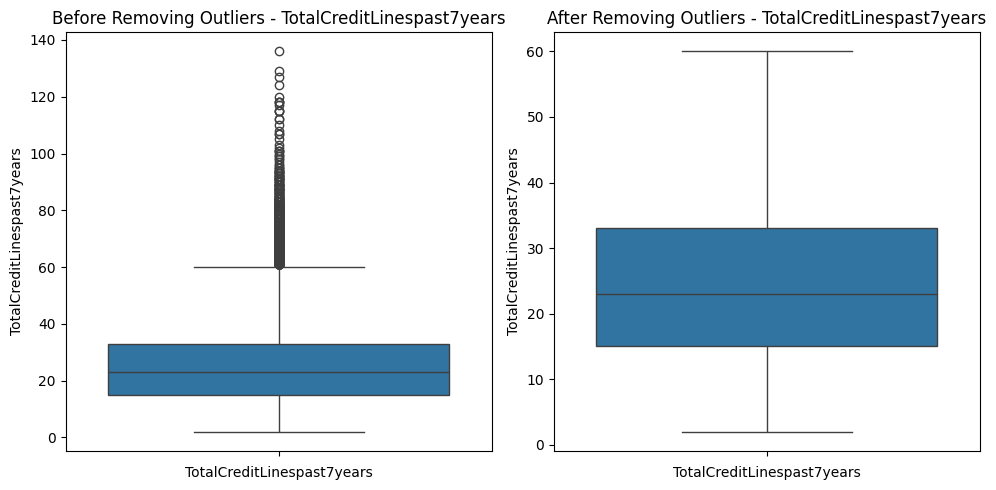

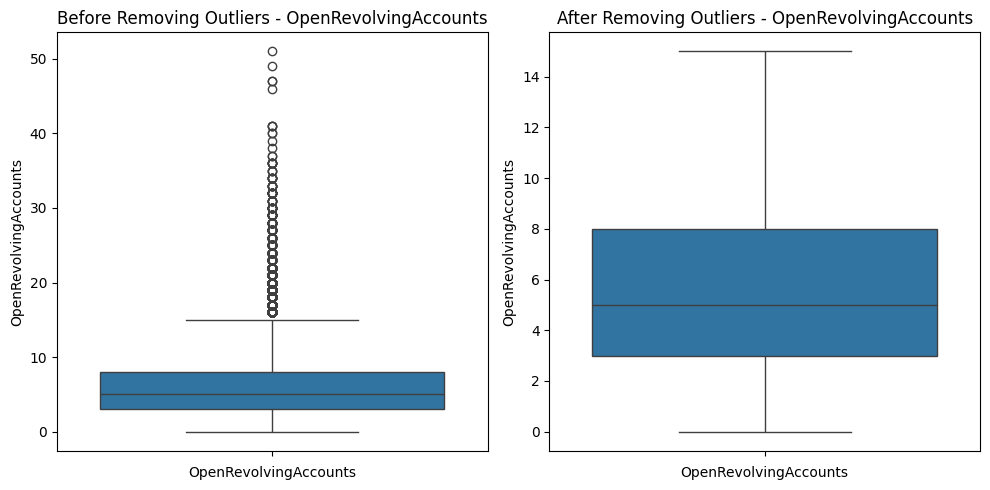

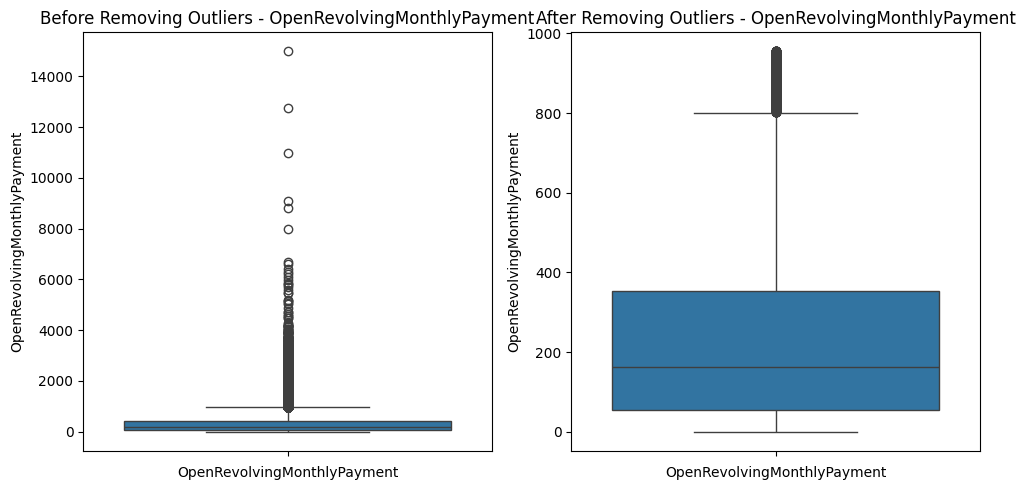

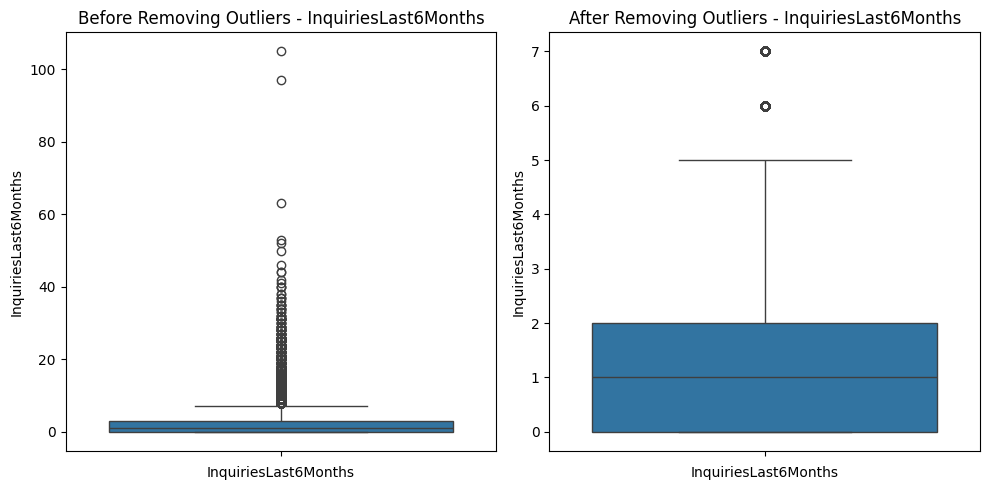

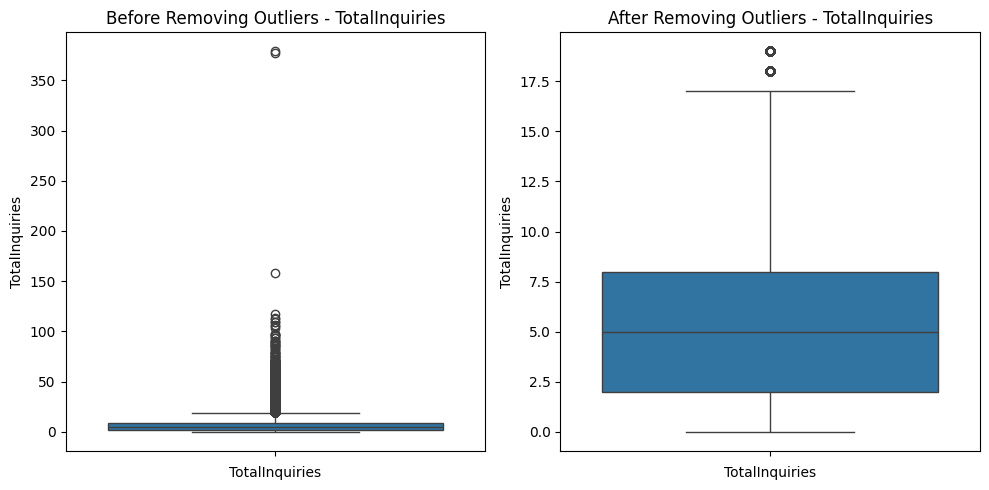

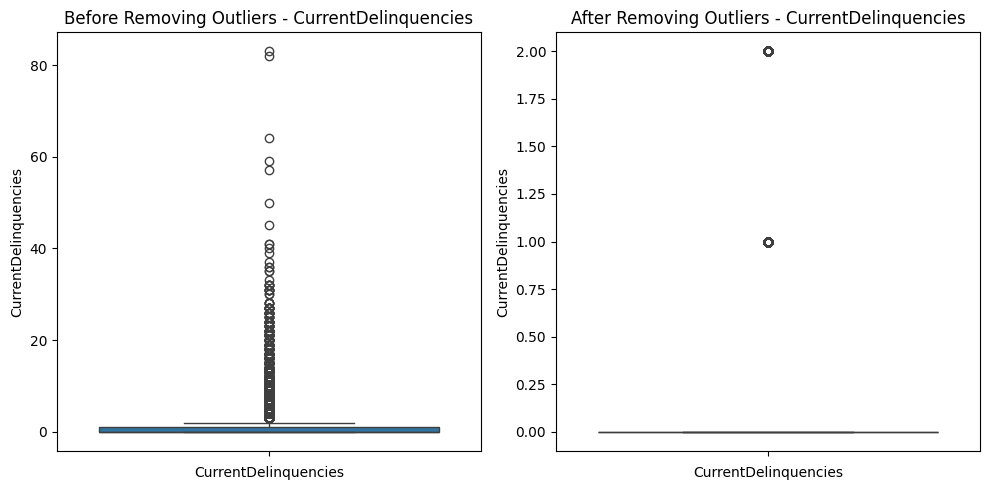

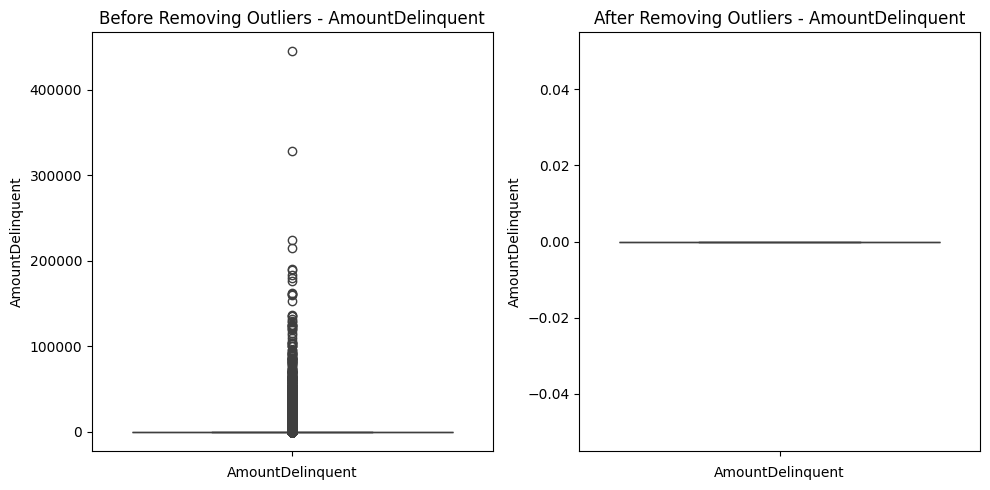

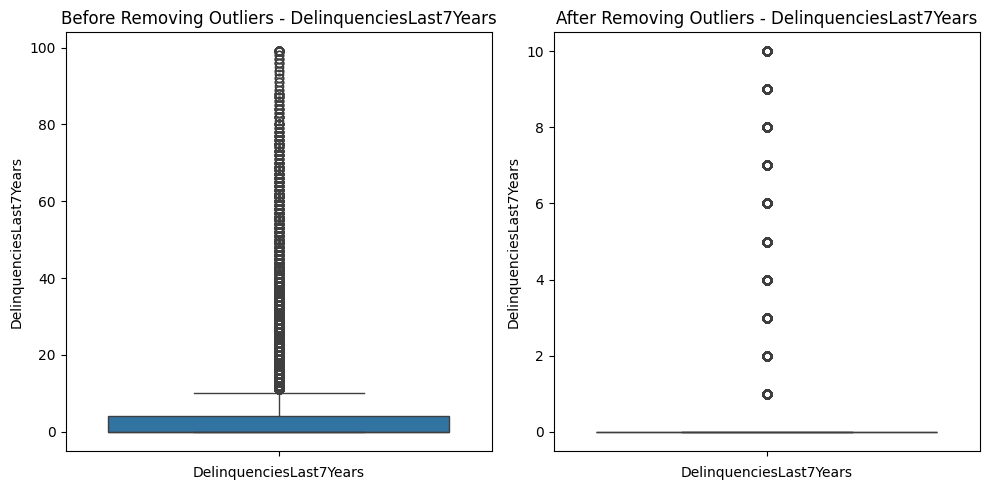

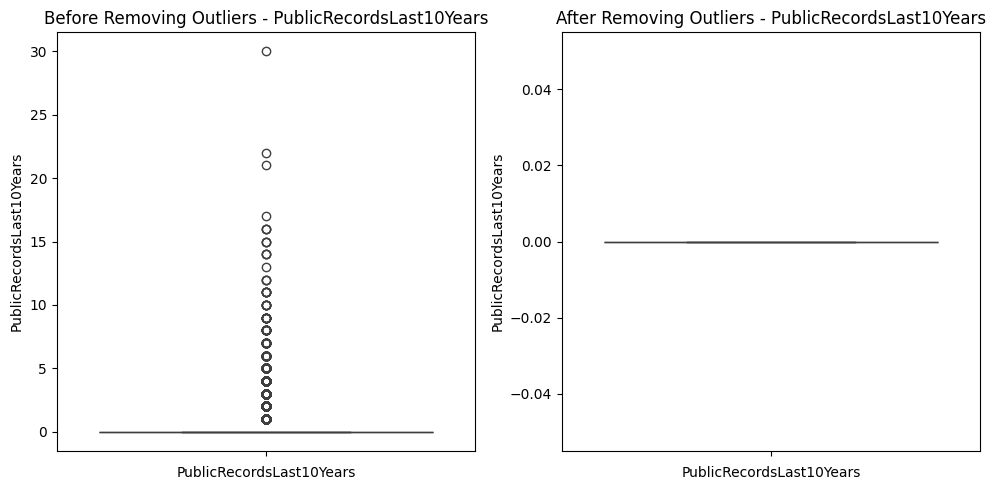

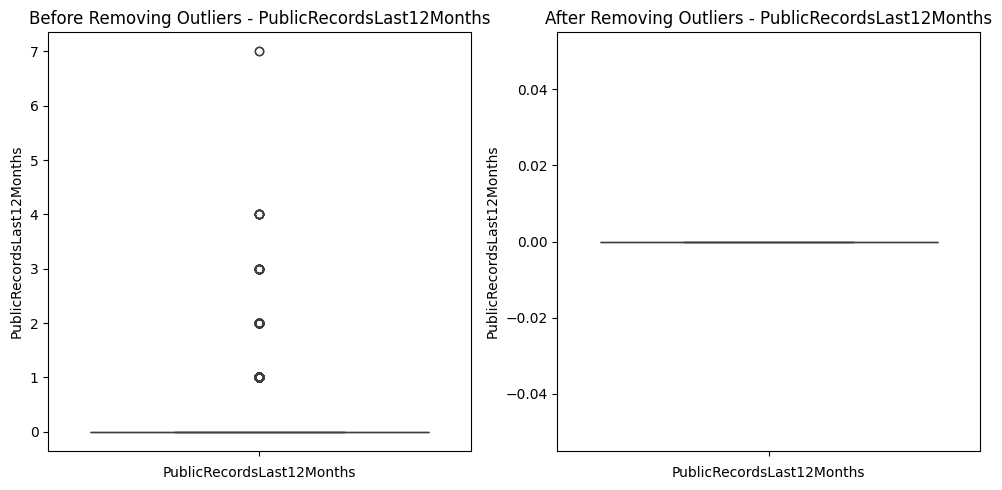

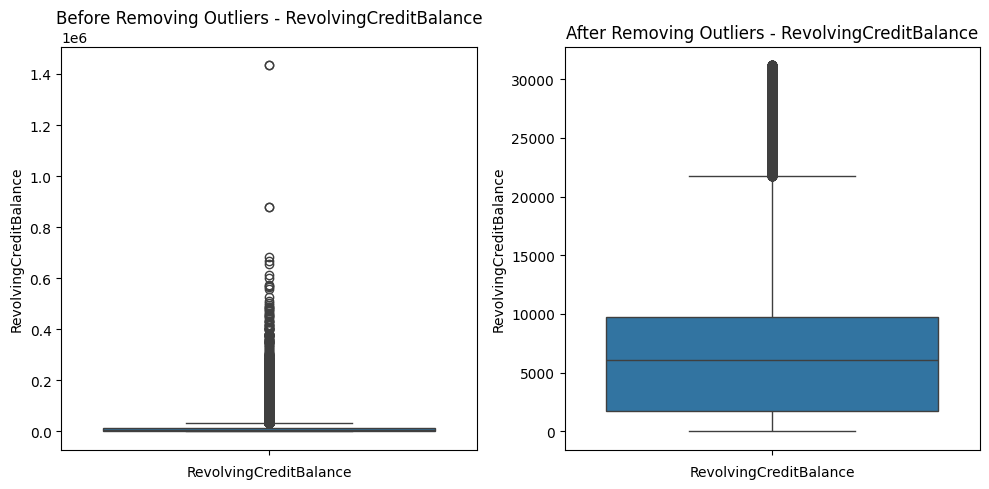

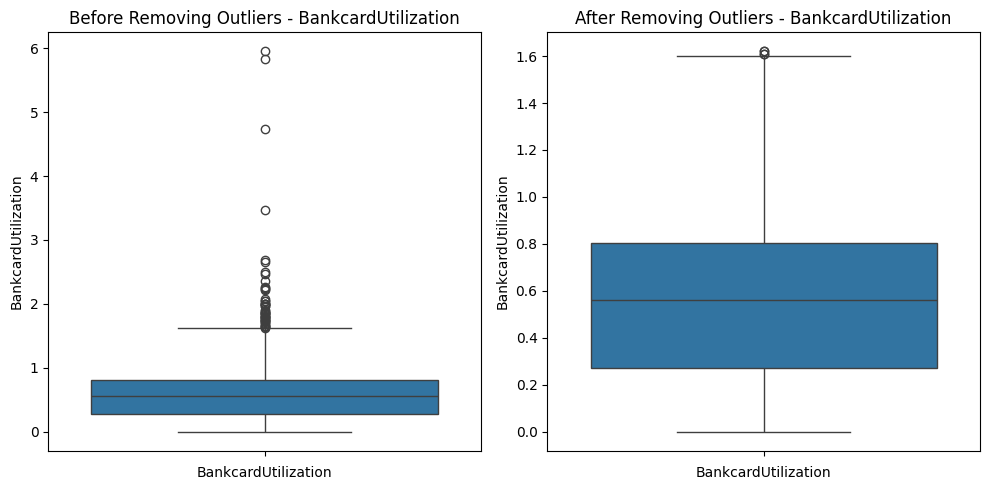

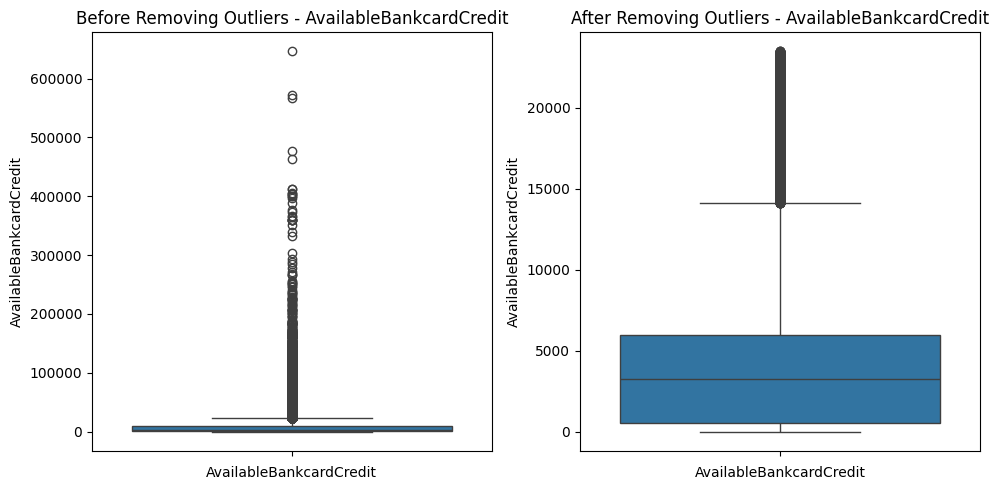

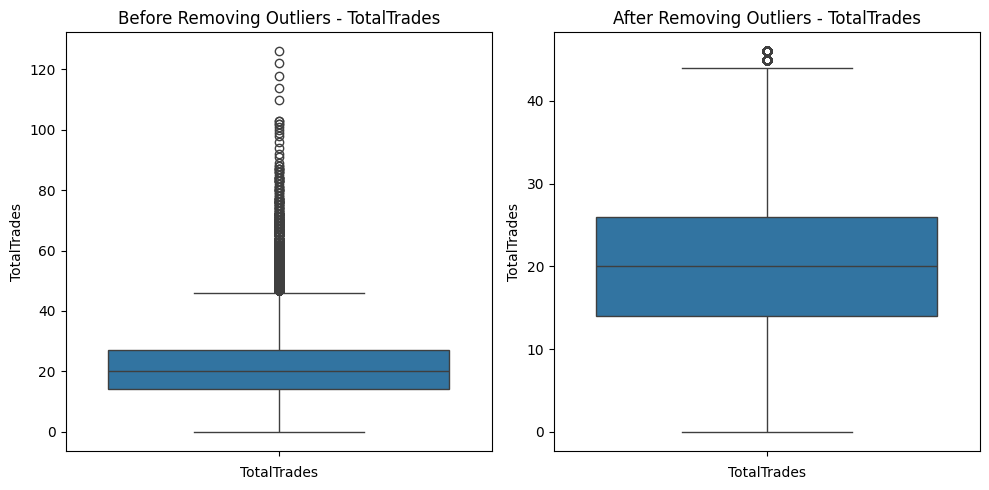

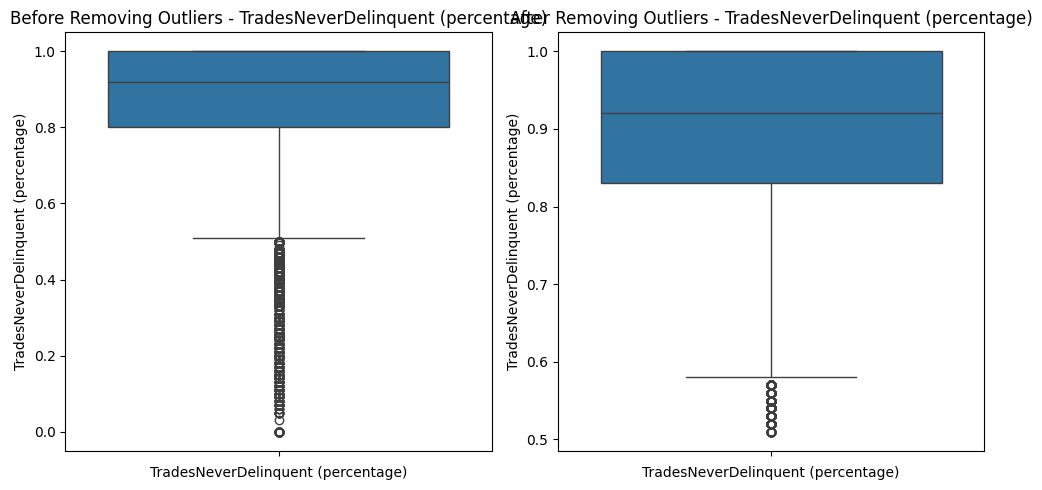

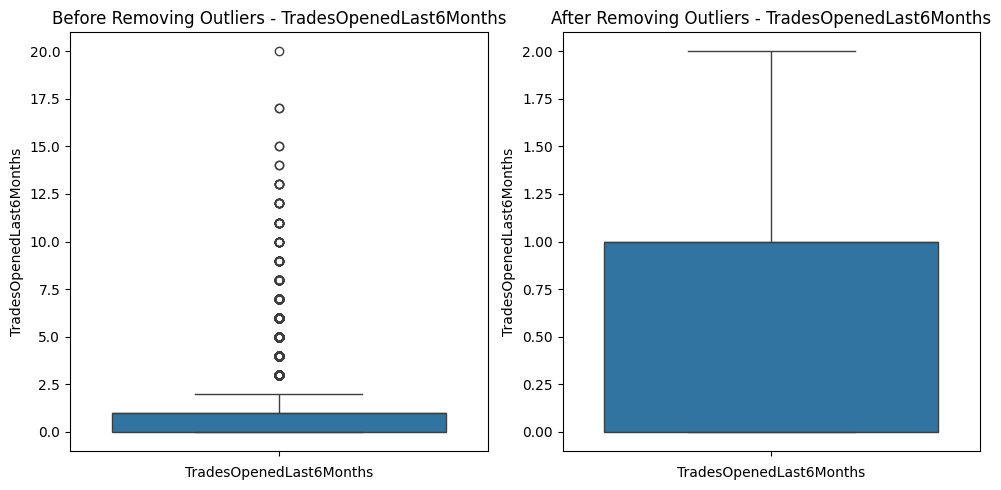

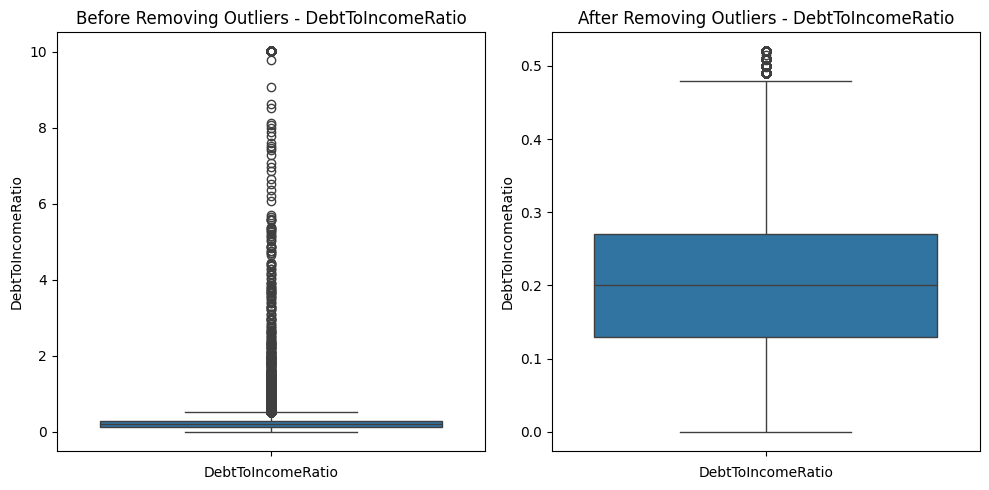

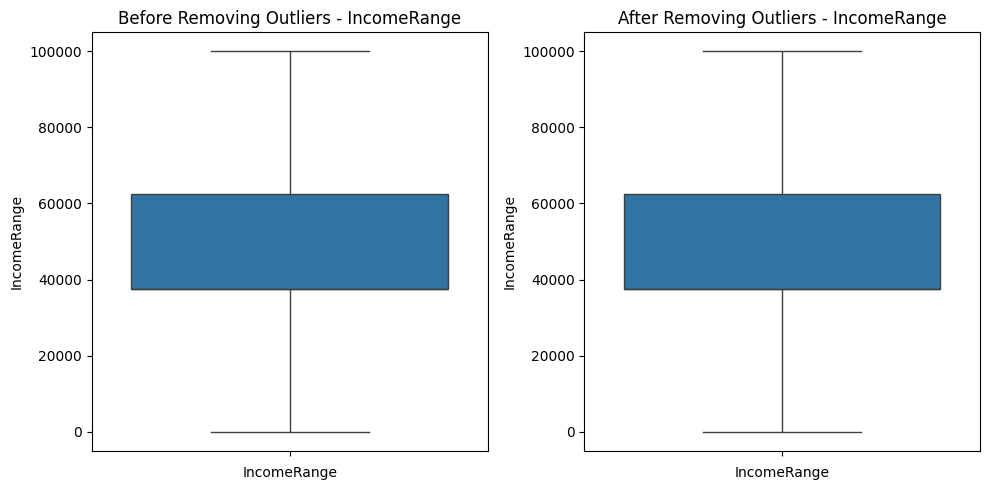

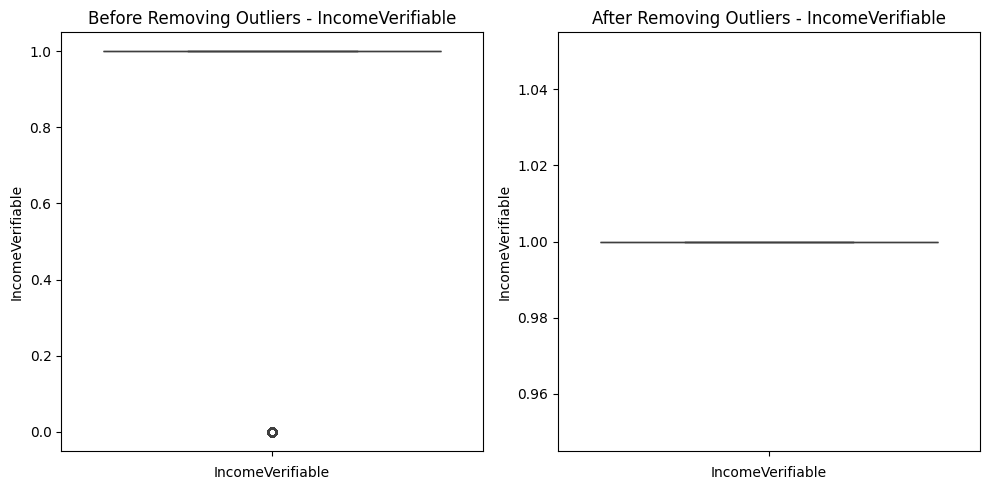

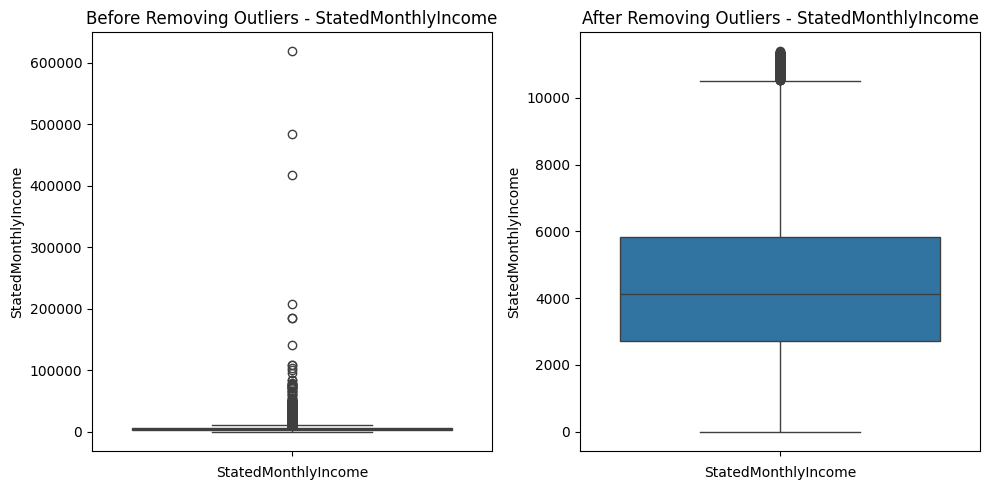

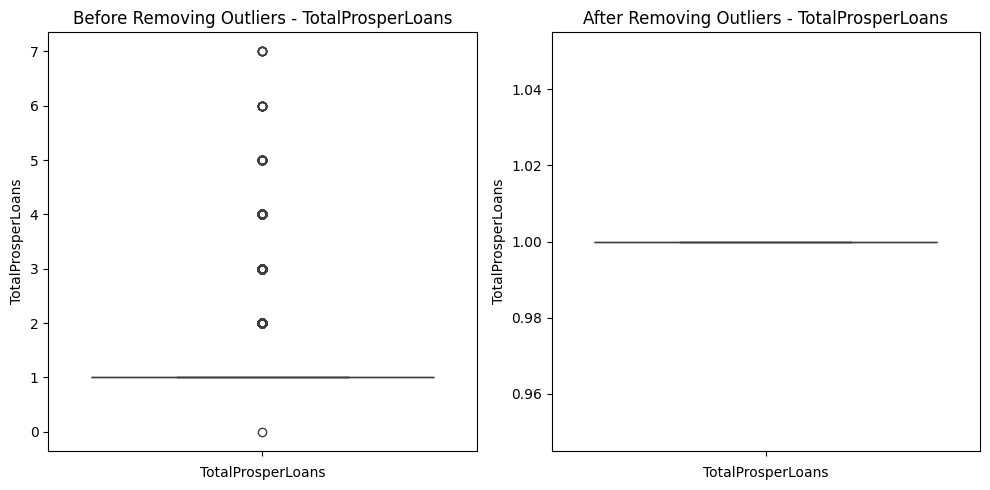

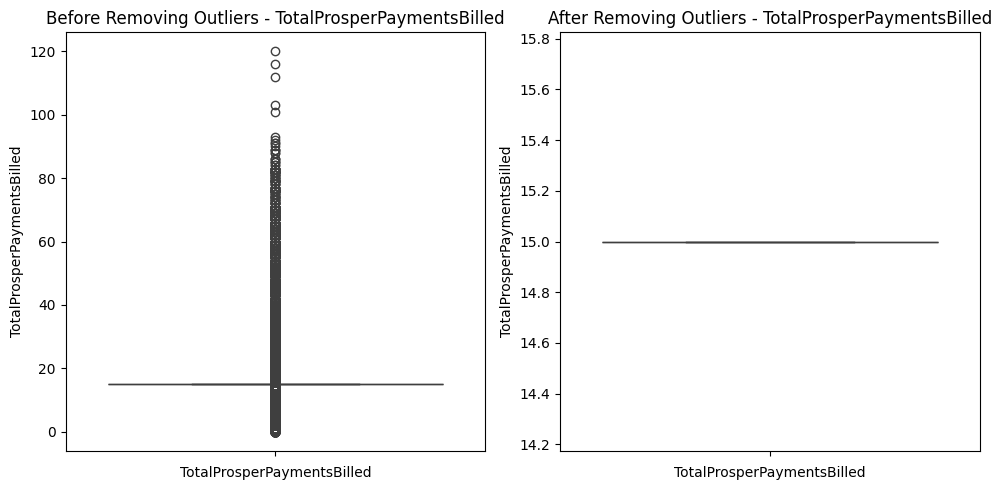

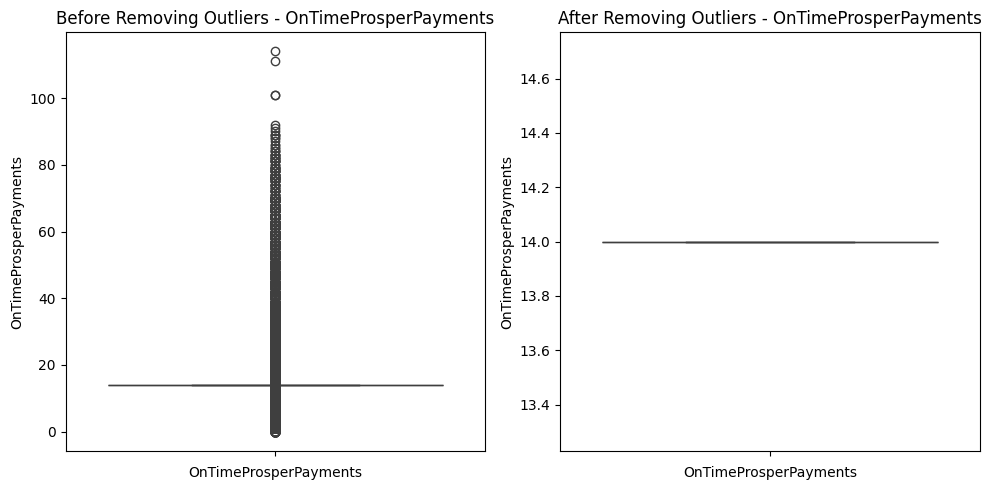

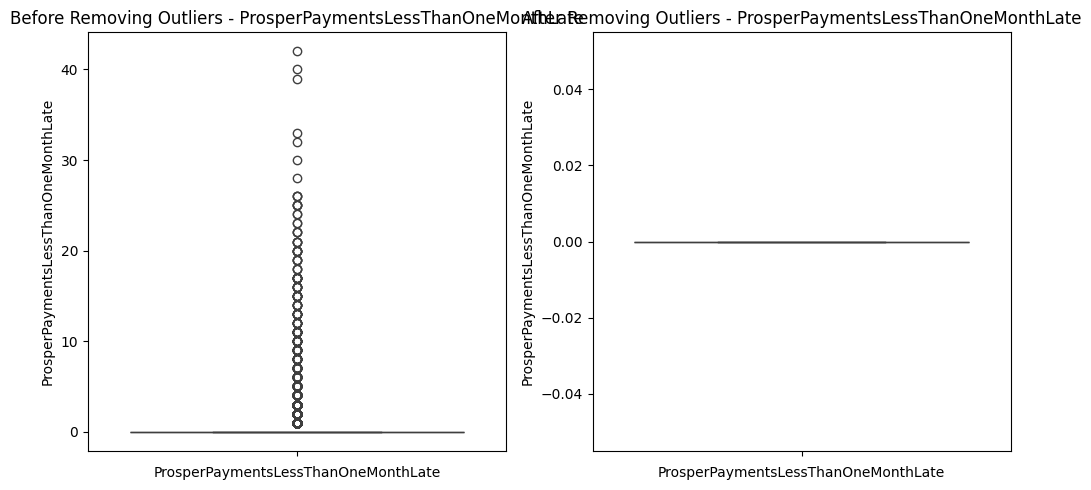

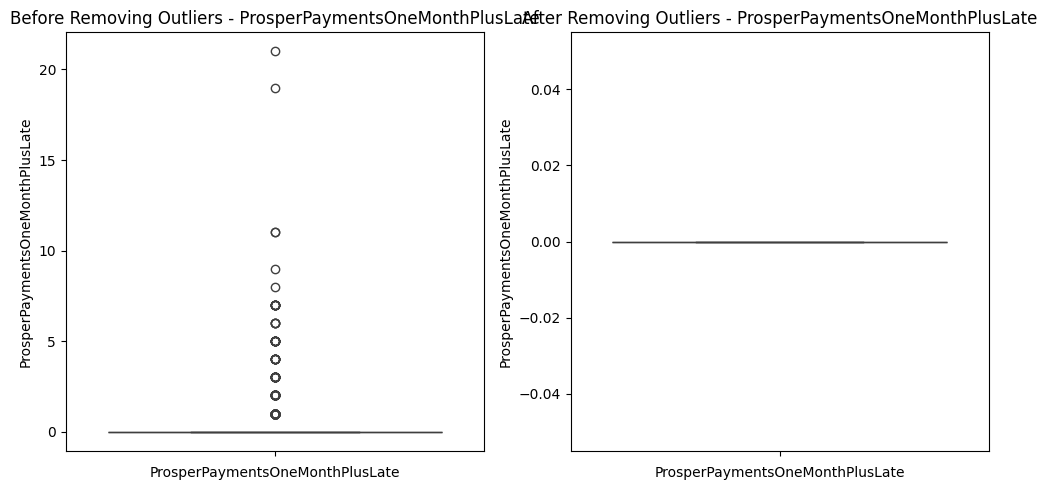

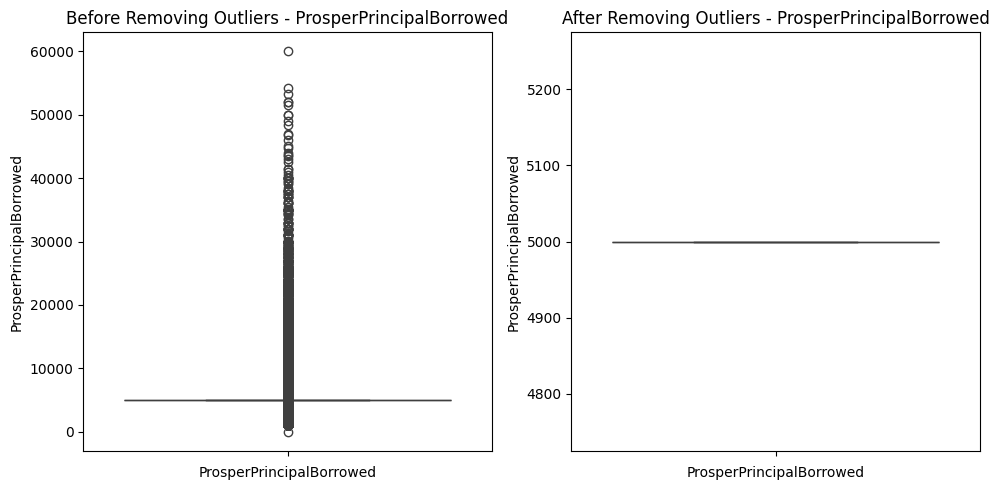

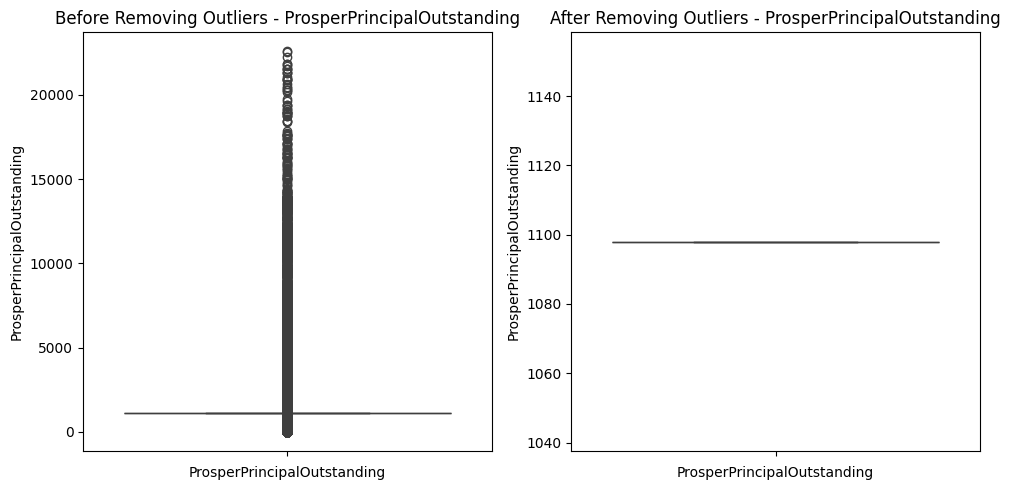

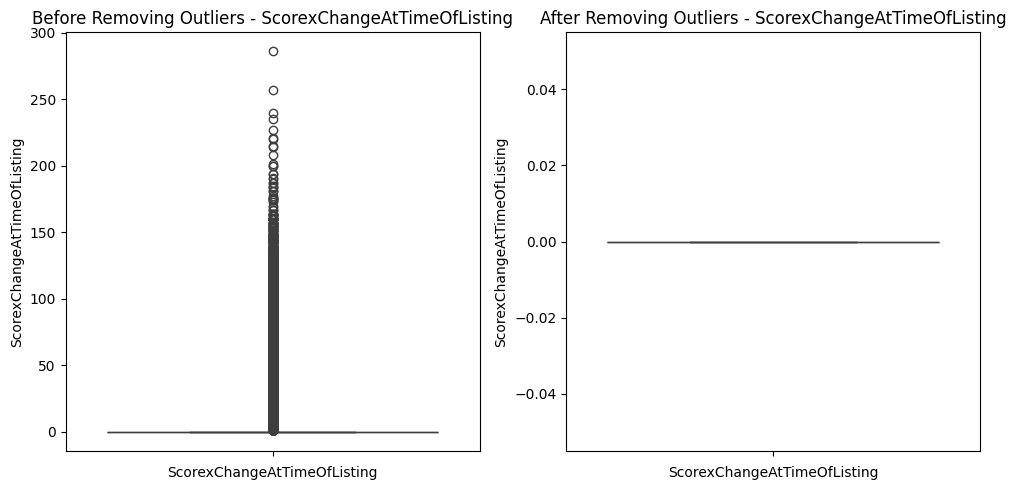

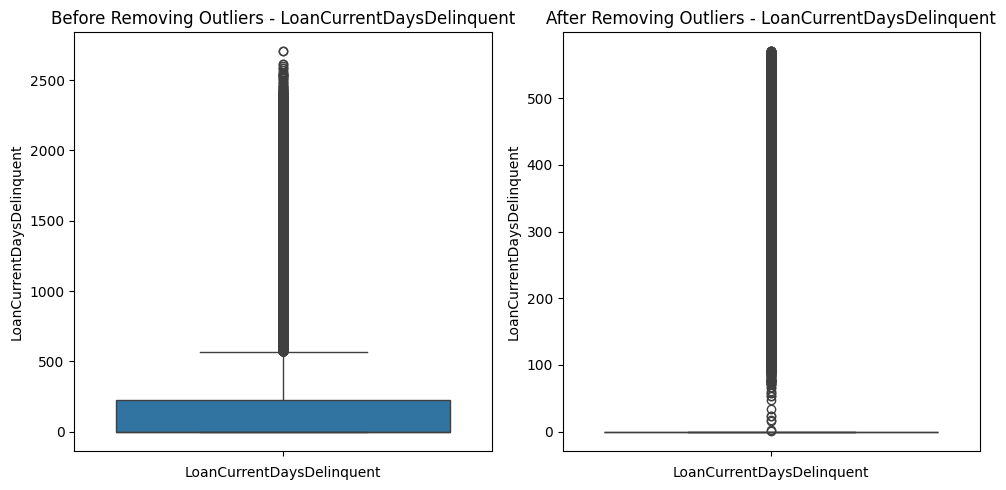

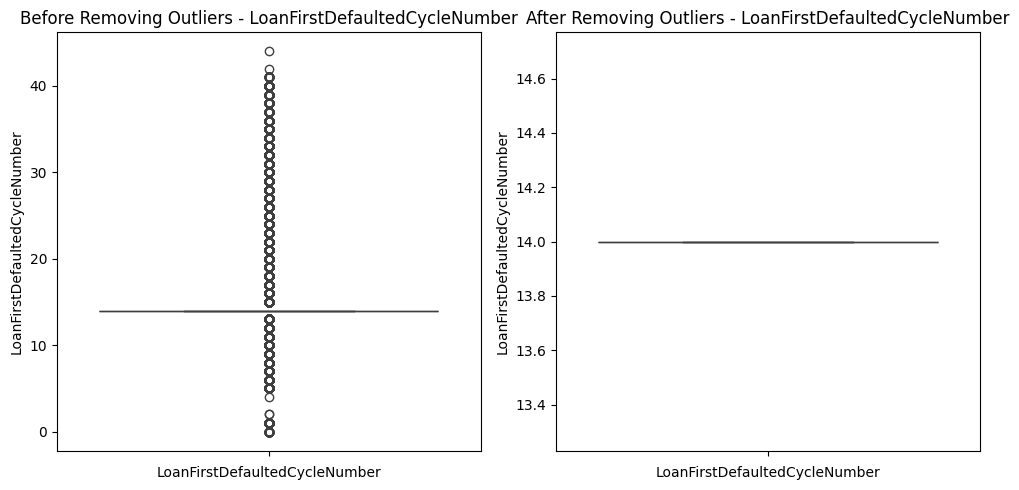

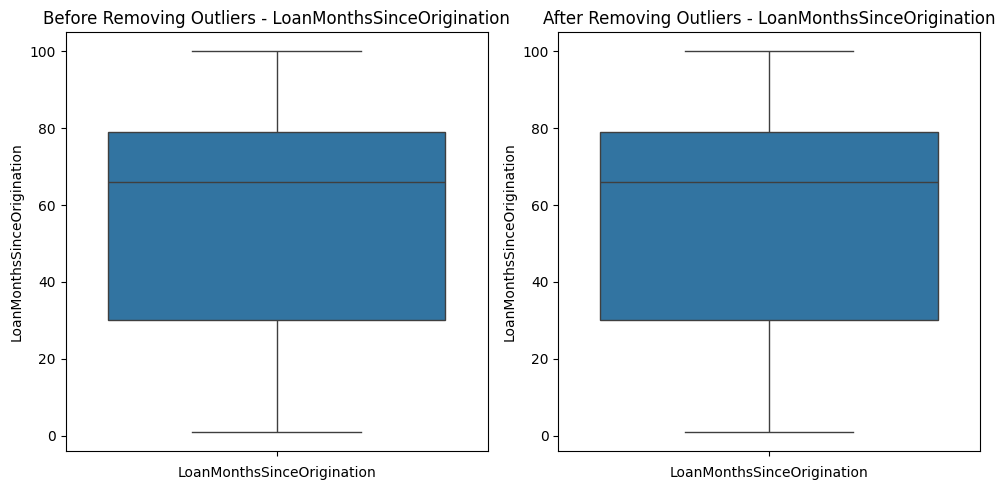

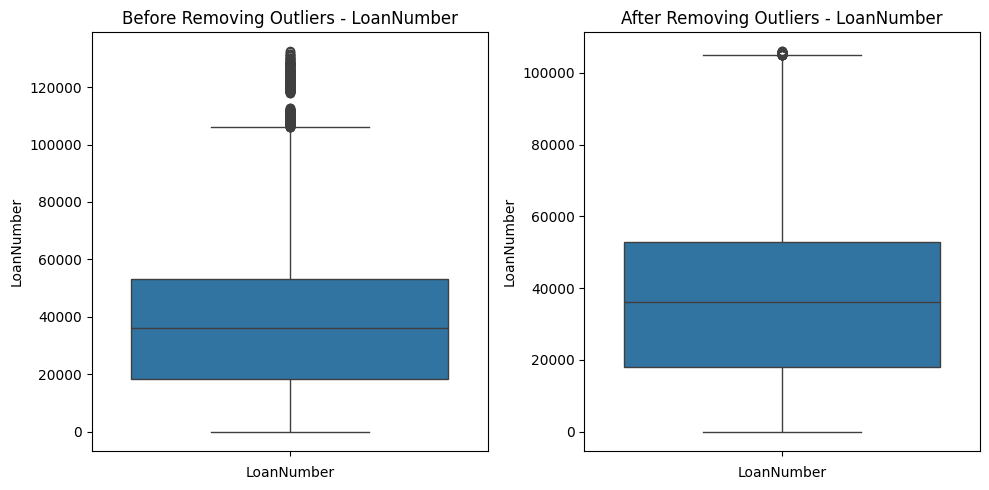

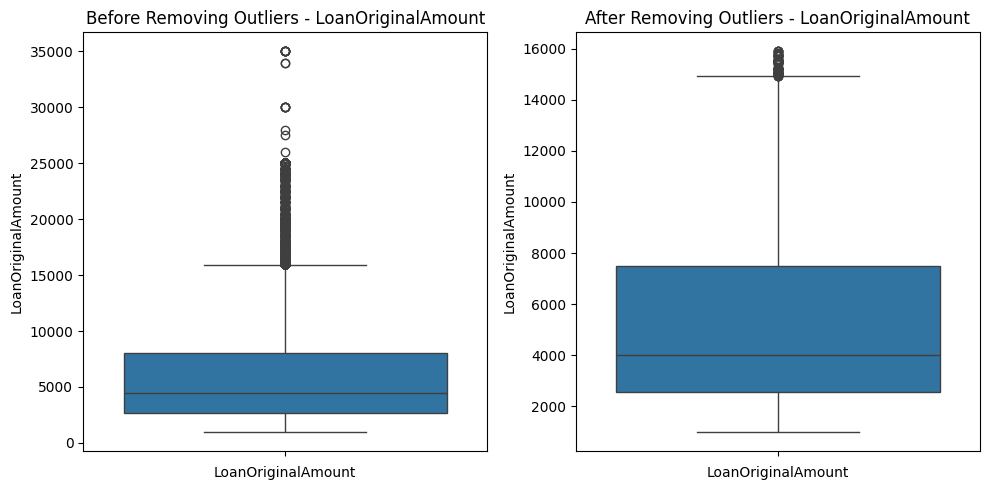

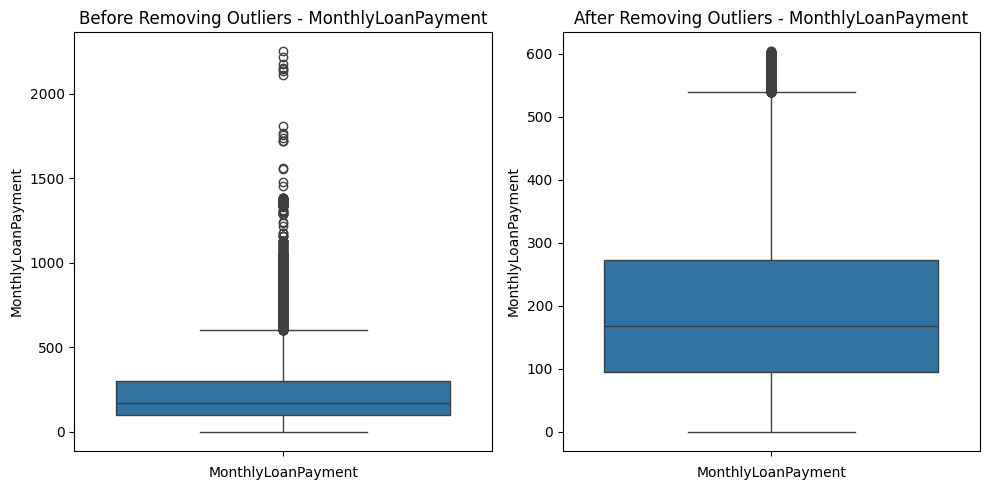

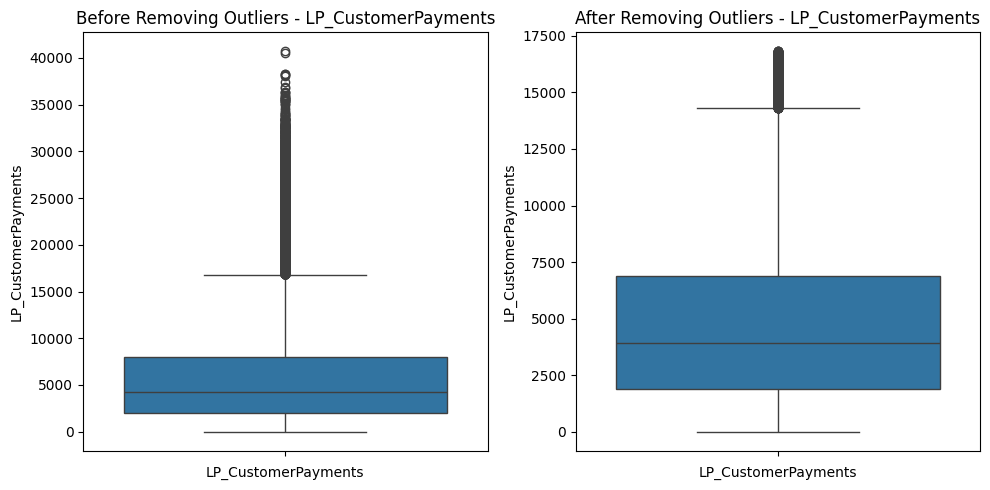

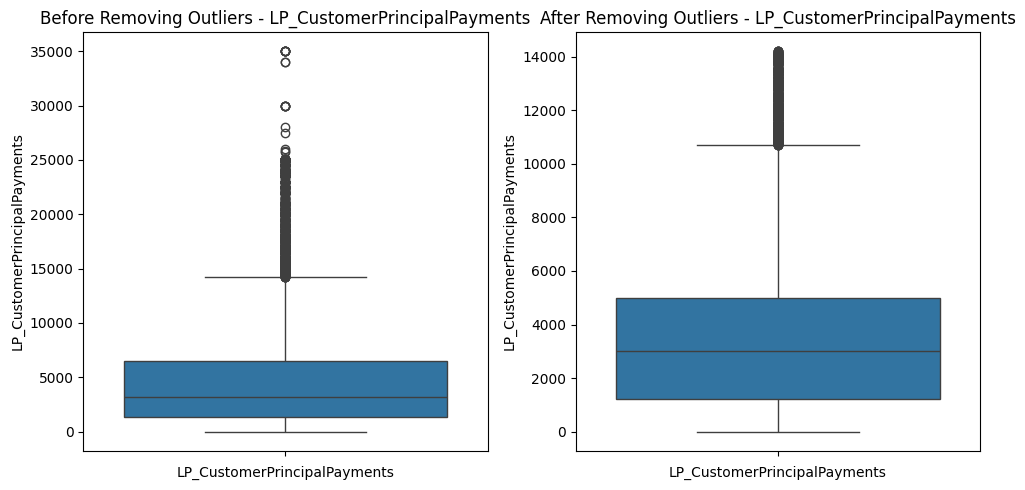

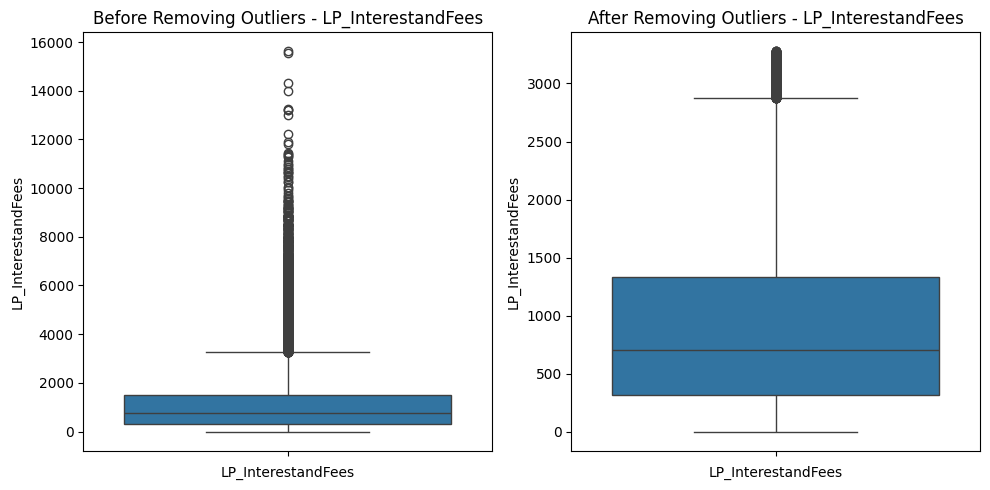

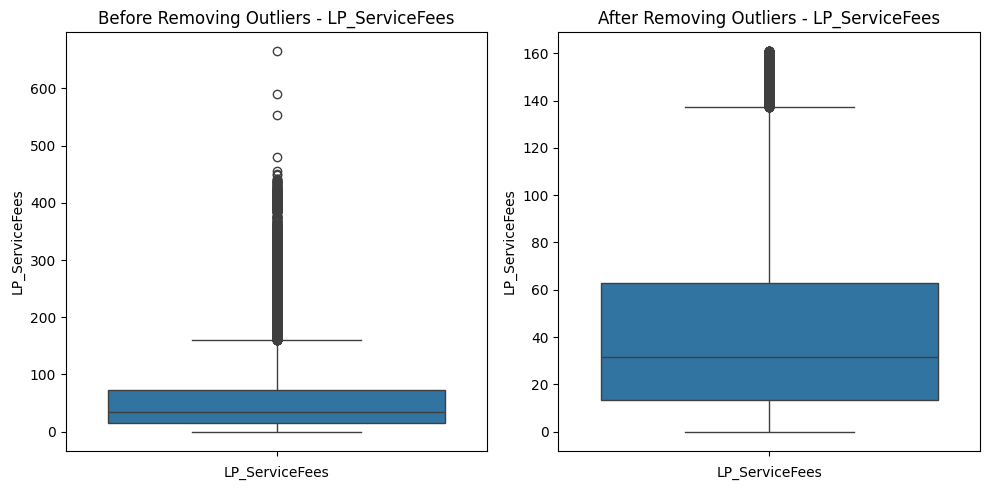

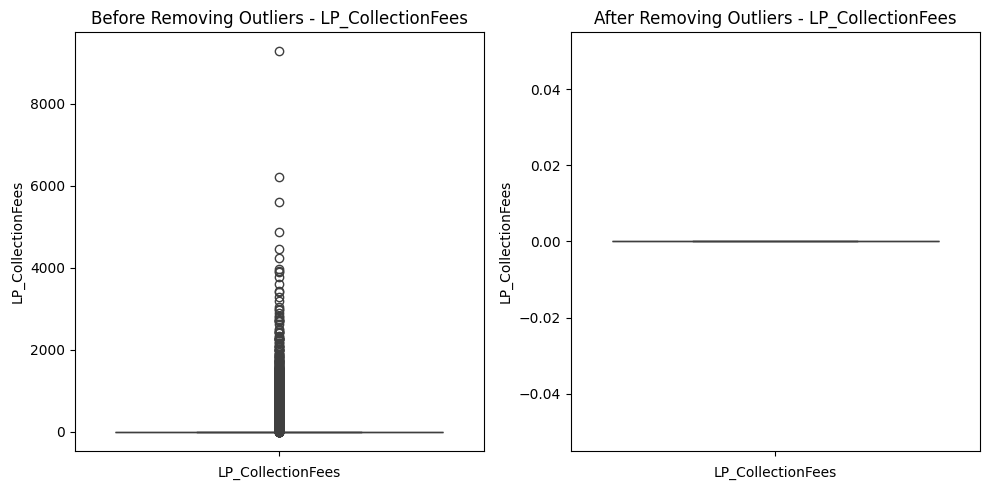

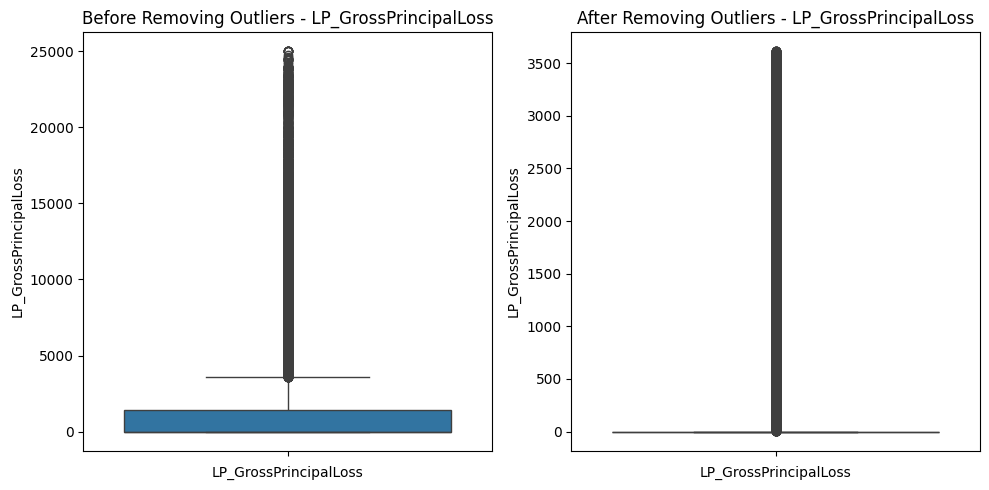

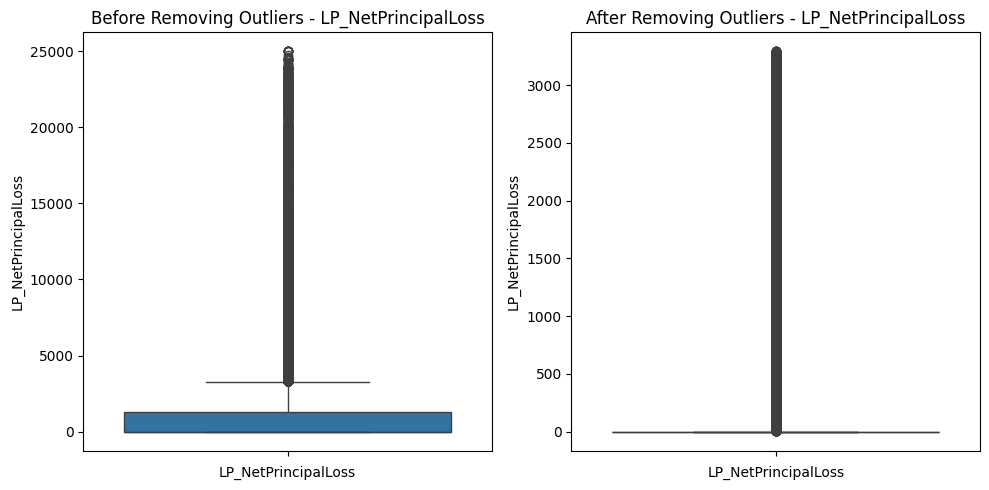

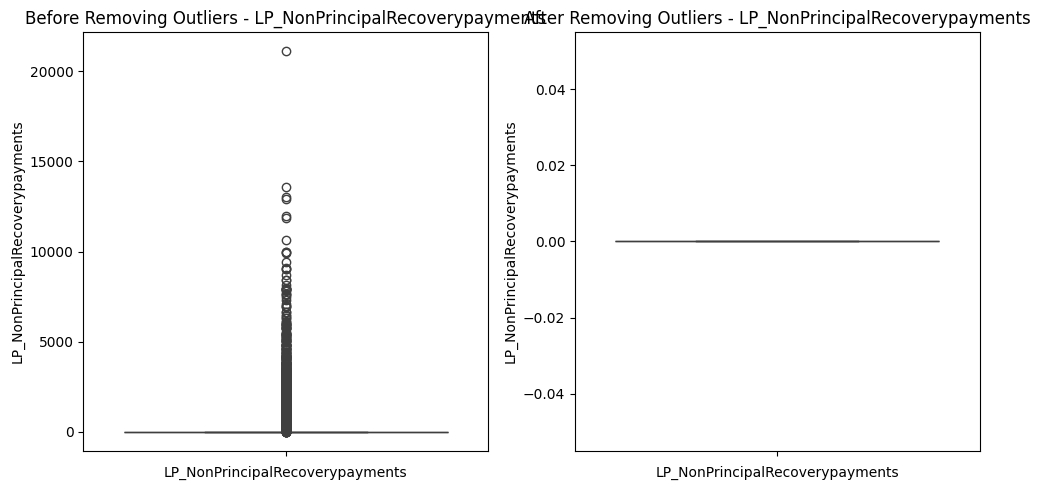

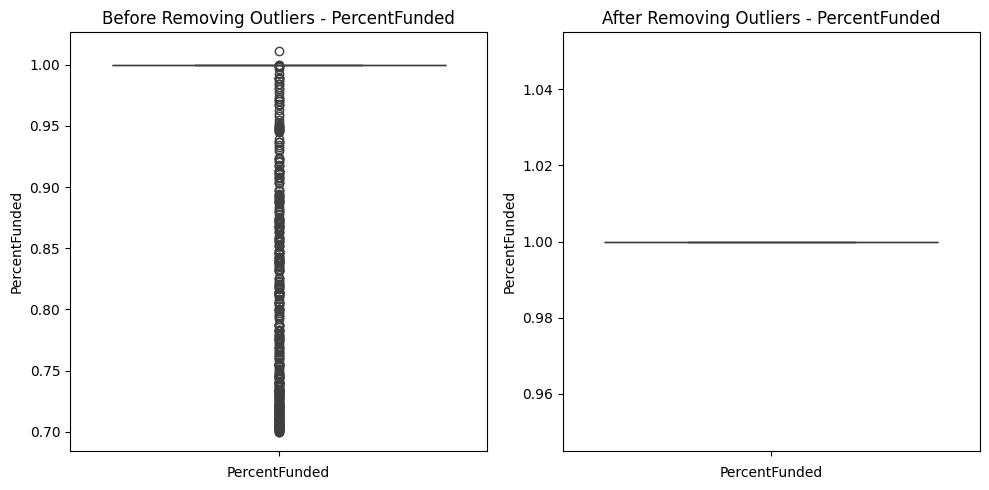

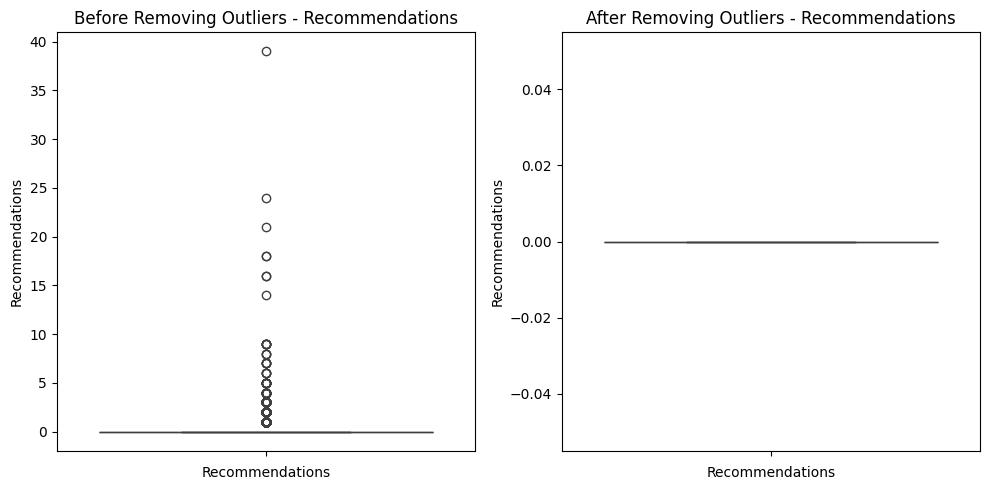

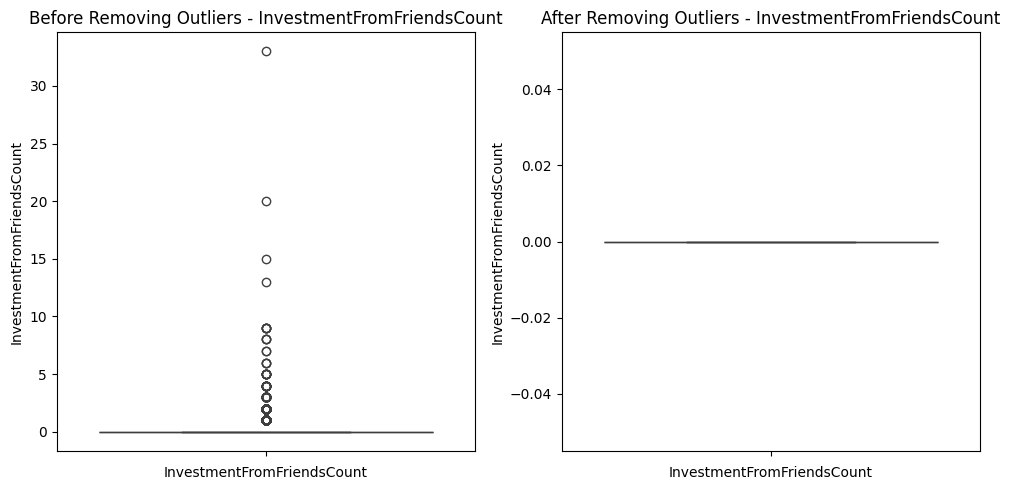

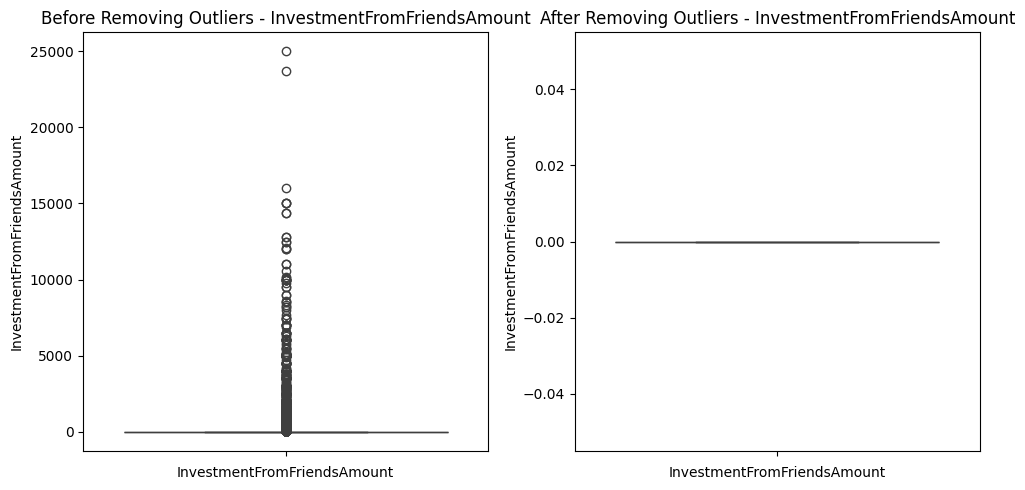

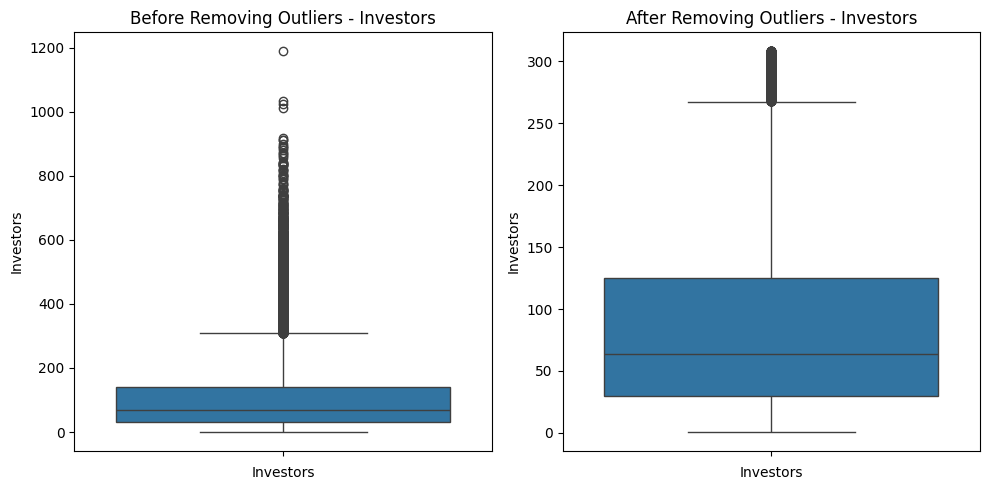

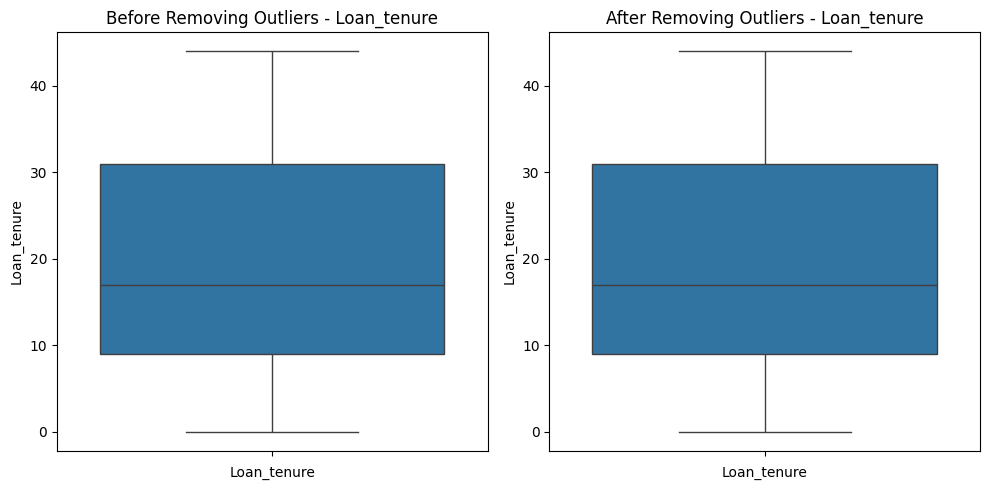

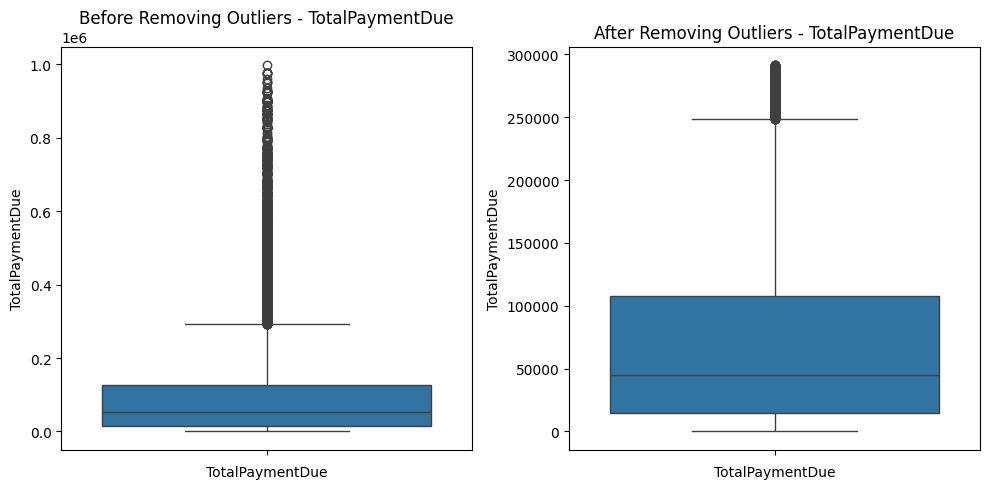

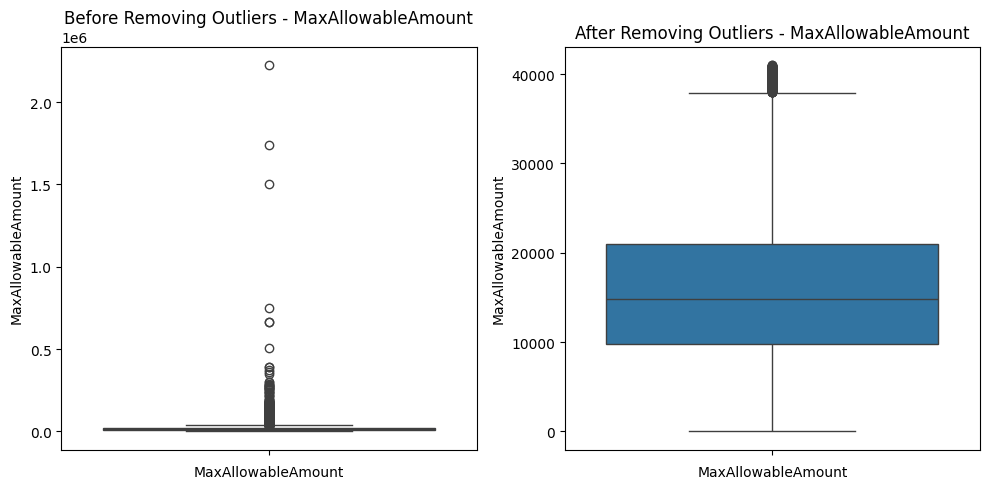

In [ ]:
columns_with_outliers = ['CreditGrade', 'Term', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState', 'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CurrentlyInGroup', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable', 'StatedMonthlyIncome', 'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed', 'ProsperPrincipalOutstanding', 'ScorexChangeAtTimeOfListing', 'LoanCurrentDaysDelinquent', 'LoanFirstDefaultedCycleNumber', 'LoanMonthsSinceOrigination', 'LoanNumber', 'LoanOriginalAmount', 'MonthlyLoanPayment', 'LP_CustomerPayments', 'LP_CustomerPrincipalPayments', 'LP_InterestandFees', 'LP_ServiceFees', 'LP_CollectionFees', 'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss', 'LP_NonPrincipalRecoverypayments', 'PercentFunded', 'Recommendations', 'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount', 'Investors', 'Loan_tenure', 'TotalPaymentDue', 'MaxAllowableAmount']
# Visualizing the data before removing outliers
for column in columns_with_outliers:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.boxplot(data[column])
    plt.title(f'Before Removing Outliers - {column}')
    plt.xlabel(column)


    # Method 2: Using Interquartile Range (IQR)
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_iqr = data[(data[column] < lower_bound) | (data[column] > upper_bound)]

    # Removing outliers
    New_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

    # Visualizing the data after removing outliers
    plt.subplot(1, 2, 2)
    sns.boxplot(New_data[column])
    plt.title(f'After Removing Outliers - {column}')
    plt.xlabel(column)

    plt.tight_layout()
    plt.show()

Extracting the features.

we have to extract the date,month,year from the datetime columns

In [ ]:
New_data['ListingCreationDate_Year'] = New_data['ListingCreationDate'].dt.year
New_data['ListingCreationDate_Month'] = New_data['ListingCreationDate'].dt.month
New_data['ListingCreationDate_Day'] = New_data['ListingCreationDate'].dt.day

<ipython-input-74-78b8b7134d39>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_data['ListingCreationDate_Year'] = New_data['ListingCreationDate'].dt.year
<ipython-input-74-78b8b7134d39>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_data['ListingCreationDate_Month'] = New_data['ListingCreationDate'].dt.month
<ipython-input-74-78b8b7134d39>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [ ]:
New_data['DateCreditPulled_Year'] = New_data['DateCreditPulled'].dt.year
New_data['DateCreditPulled_Month'] = New_data['DateCreditPulled'].dt.month
New_data['DateCreditPulled_Day'] = New_data['DateCreditPulled'].dt.day

<ipython-input-75-884b7c8f399a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_data['DateCreditPulled_Year'] = New_data['DateCreditPulled'].dt.year
<ipython-input-75-884b7c8f399a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_data['DateCreditPulled_Month'] = New_data['DateCreditPulled'].dt.month
<ipython-input-75-884b7c8f399a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [ ]:
New_data['LoanOriginationDate_Year'] = New_data['LoanOriginationDate'].dt.year
New_data['LoanOriginationDate_Month'] = New_data['LoanOriginationDate'].dt.month
New_data['LoanOriginationDate_Day'] = New_data['LoanOriginationDate'].dt.day

<ipython-input-76-c5972fdfb3a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_data['LoanOriginationDate_Year'] = New_data['LoanOriginationDate'].dt.year
<ipython-input-76-c5972fdfb3a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_data['LoanOriginationDate_Month'] = New_data['LoanOriginationDate'].dt.month
<ipython-input-76-c5972fdfb3a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [ ]:
New_data['Closeddate_year'] = New_data['ClosedDate'].dt.year
New_data['Closeddate_Month'] = New_data['ClosedDate'].dt.month
New_data['Closeddate_Day'] = New_data['ClosedDate'].dt.day

<ipython-input-77-81579856f9c2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_data['Closeddate_year'] = New_data['ClosedDate'].dt.year
<ipython-input-77-81579856f9c2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_data['Closeddate_Month'] = New_data['ClosedDate'].dt.month
<ipython-input-77-81579856f9c2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
New_data.drop('ListingCreationDate', axis=1, inplace=True)
New_data.drop('DateCreditPulled', axis=1, inplace=True)
New_data.drop('FirstRecordedCreditLine', axis=1, inplace=True)
New_data.drop('LoanOriginationDate', axis=1, inplace=True)
New_data.drop('ClosedDate', axis=1, inplace=True)

<ipython-input-78-d5e1731eb4ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_data.drop('ListingCreationDate', axis=1, inplace=True)
<ipython-input-78-d5e1731eb4ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_data.drop('DateCreditPulled', axis=1, inplace=True)
<ipython-input-78-d5e1731eb4ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_data.drop('FirstRecordedCreditLine', axis=1, inplace=True)
<ipython-input-78-

Save the cleaned data.

In [ ]:
New_data.to_csv('test_data.csv', index=False)
print("Cleaned data saved successfully.")


Cleaned data saved successfully.


Feature scaling

Divide the data into x, y_class, y_multi

In [ ]:
# Separate features and targets
X = New_data.drop(columns=['EMI', 'EligibleLoanAmount', 'PROI', 'LoanStatus'])
y_class = New_data['LoanStatus']
y_multi = New_data[['EMI', 'EligibleLoanAmount', 'PROI']]

Check the MI scores for each target variable

In [ ]:
# Calculate Mutual Information (MI) scores for each target variable
mi_scores_dict = {}
for target in y_multi.columns:
    mi_scores = mutual_info_regression(X, y_multi[target], discrete_features='auto', random_state=42)
    mi_scores_dict[target] = mi_scores

# Create a DataFrame to display MI scores for each feature and each target variable
mi_df = pd.DataFrame(mi_scores_dict, index=X.columns)
mi_df.index.name = 'Feature'

# Display the MI scores
print(mi_df.sort_values(by='EMI', ascending=False))

                                          EMI  EligibleLoanAmount      PROI
Feature                                                                    
TotalPaymentDue                      4.603611            0.809604  0.537857
LP_CustomerPrincipalPayments         2.570560            1.600919  0.836971
LoanOriginalAmount                   1.558513            0.308243  0.310313
Loan_tenure                          1.524611            0.324683  0.192797
LP_CustomerPayments                  1.373163            0.688259  0.466150
...                                       ...                 ...       ...
ProsperPaymentsLessThanOneMonthLate  0.002837            0.000000  0.000382
LoanOriginationDate_Day              0.002648            0.004065  0.000504
PercentFunded                        0.000499            0.003704  0.001183
ProsperPaymentsOneMonthPlusLate      0.000000            0.000000  0.006717
DateCreditPulled_Day                 0.000000            0.005535  0.000846

[86 rows x 

In [ ]:
# Function to select top 10 features based on MI scores for each target
def select_top_features(mi_df, top_n=20):
    top_features_dict = {}
    for target in mi_df.columns:
        top_features = mi_df[target].sort_values(ascending=False).head(top_n).index
        top_features_dict[target] = top_features
    return top_features_dict

# Select top 10 features for each target variable
top_features_dict = select_top_features(mi_df, top_n=20)

# Display the top 10 features for each target variable
for target, features in top_features_dict.items():
    print(f"Top 10 features for {target}:")
    for feature in features:
        print(feature)
    print()


Top 10 features for EMI:
TotalPaymentDue
LP_CustomerPrincipalPayments
LoanOriginalAmount
Loan_tenure
LP_CustomerPayments
TotalAmount
LP_ServiceFees
MonthlyLoanPayment
InterestAmount
LP_GrossPrincipalLoss
LP_NetPrincipalLoss
ROI
BorrowerRate
LenderYield
BorrowerAPR
LP_InterestandFees
LoanFirstDefaultedCycleNumber
EstimatedLoss
EstimatedEffectiveYield
ProsperRating (numeric)

Top 10 features for EligibleLoanAmount:
LP_CustomerPrincipalPayments
TotalPaymentDue
LP_CustomerPayments
LP_GrossPrincipalLoss
LP_NetPrincipalLoss
LP_ServiceFees
Loan_tenure
LoanOriginalAmount
TotalAmount
LoanFirstDefaultedCycleNumber
LP_InterestandFees
MonthlyLoanPayment
LoanCurrentDaysDelinquent
InterestAmount
BorrowerAPR
ROI
LenderYield
BorrowerRate
Closeddate_year
EstimatedEffectiveYield

Top 10 features for PROI:
LP_CustomerPrincipalPayments
LP_GrossPrincipalLoss
LP_NetPrincipalLoss
LoanFirstDefaultedCycleNumber
LoanCurrentDaysDelinquent
TotalPaymentDue
MonthlyLoanPayment
LP_CustomerPayments
TotalAmount
LoanOri

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
n_components = 30  # Number of principal components
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train XGBoost classifier
xgb_clf = XGBClassifier(random_state=42)
xgb_clf.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = xgb_clf.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.9630303610765253
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93      2893
           1       0.98      0.97      0.97      7548

    accuracy                           0.96     10441
   macro avg       0.95      0.96      0.95     10441
weighted avg       0.96      0.96      0.96     10441



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training and testing sets
X_train, X_test, y_train_multi, y_test_multi = train_test_split(X, y_multi, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Initialize the MultiOutputRegressor
mor = MultiOutputRegressor(rf)

# Fit the model on scaled data
mor.fit(X_train_scaled, y_train_multi)

# Predict on the scaled test set
y_pred_multi = mor.predict(X_test_scaled)

# Ensure y_test_multi and y_pred_multi are NumPy arrays
if isinstance(y_test_multi, pd.DataFrame):
    y_test_multi = y_test_multi.values
if isinstance(y_pred_multi, pd.DataFrame):
    y_pred_multi = y_pred_multi.values

# Calculate Mean Squared Error and R^2 score for each target variable
mse_list = []
r2_list = []

for i in range(y_test_multi.shape[1]):
    mse = mean_squared_error(y_test_multi[:, i], y_pred_multi[:, i])
    r2 = r2_score(y_test_multi[:, i], y_pred_multi[:, i])
    mse_list.append(mse)
    r2_list.append(r2)

# Print the scores for each target variable
for idx, (mse, r2) in enumerate(zip(mse_list, r2_list), start=1):
    print(f'Target Variable {idx}:')
    print(f'  Mean Squared Error: {mse}')
    print(f'  R^2 Score: {r2}')

# Optionally, print the overall scores if needed
overall_mse = mean_squared_error(y_test_multi, y_pred_multi)
overall_r2 = r2_score(y_test_multi, y_pred_multi)

print(f'Overall Mean Squared Error: {overall_mse}')
print(f'Overall R^2 Score: {overall_r2}')

Target Variable 1:
  Mean Squared Error: 2286.3315110758886
  R^2 Score: 0.9985361425053115
Target Variable 2:
  Mean Squared Error: 141812.66094129987
  R^2 Score: 0.9172078085419874
Target Variable 3:
  Mean Squared Error: 2.93956517574944e-06
  R^2 Score: 0.9992366904417856
Overall Mean Squared Error: 48032.997485105116
Overall R^2 Score: 0.9716602138296948


Pipeline

In [ ]:
df= pd.read_csv('test_data.csv')

In [ ]:
columns = df.columns.tolist()
print(columns)


['CreditGrade', 'Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperRating (numeric)', 'ProsperScore', 'ListingCategory (numeric)', 'BorrowerState', 'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CurrentlyInGroup', 'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent (percentage)', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'IncomeRange', 'IncomeVerifiable', 'StatedMonthlyIncome', 'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', '

In [ ]:
class CombinedPipeline:
    def __init__(self, classification_pipeline, regression_pipeline):
        self.classification_pipeline = classification_pipeline
        self.regression_pipeline = regression_pipeline

    def fit(self, X_train, y_train_class, y_train_multi):
        # Fit the classification pipeline
        self.classification_pipeline.fit(X_train, y_train_class)

        # Predict LoanStatus for training set and augment data
        X_train_augmented = X_train.copy()
        X_train_augmented['PredictedLoanStatus'] = self.classification_pipeline.predict(X_train)

        # Fit the regression pipeline
        self.regression_pipeline.fit(X_train_augmented, y_train_multi)

    def predict(self, X_test):
        # Predict LoanStatus for test set and augment data
        X_test_augmented = X_test.copy()
        X_test_augmented['PredictedLoanStatus'] = self.classification_pipeline.predict(X_test)

        # Predict using the regression pipeline
        y_pred_multi = self.regression_pipeline.predict(X_test_augmented)
        return y_pred_multi

    def evaluate(self, X_test, y_test_multi):
        y_pred_multi = self.predict(X_test)
        for i, col in enumerate(y_test_multi.columns):
            print(f"Metrics for {col}:")
            print(f"Mean Squared Error: {mean_squared_error(y_test_multi[col], y_pred_multi[:, i])}")
            print(f"R^2 Score: {r2_score(y_test_multi[col], y_pred_multi[:, i])}")

# Create the combined pipeline
combined_pipeline = CombinedPipeline(classification_pipeline, regression_pipeline)

# Train the combined pipeline
combined_pipeline.fit(X_train, y_train_class, y_train_multi)


NameError: name 'classification_pipeline' is not defined

In [ ]:
# Evaluate the combined pipeline
combined_pipeline.evaluate(X_test, y_test_multi)


Metrics for EMI:
Mean Squared Error: 2142.218386605272
R^2 Score: 0.9986284130602671
Metrics for EligibleLoanAmount:
Mean Squared Error: 141244.98825463658
R^2 Score: 0.9175392237022963
Metrics for PROI:
Mean Squared Error: 2.9380806436164956e-06
R^2 Score: 0.9992370759265424


Predicting the Target variables with using the real input values

In [ ]:
import pandas as pd

# Example function to prepare input data with 15 features
def prepare_own_data(input_data):
    # Replace with your feature selection logic based on your input_data
    selected_features = ['LP_CustomerPrincipalPayments', 'TotalPaymentDue', 'LP_CustomerPayments',
                         'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss', 'LoanFirstDefaultedCycleNumber',
                         'MonthlyLoanPayment', 'TotalAmount', 'LoanOriginalAmount', 'InterestAmount',
                         'Loan_tenure', 'LP_ServiceFees', 'BorrowerAPR', 'ROI', 'BorrowerRate']

    input_features = {key: input_data[key] for key in selected_features}

    # Prepare input data with 84 columns expected by model
    expected_columns = list(X_train.columns)  # Assuming X_train.columns contains all 84 feature names
    user_df = pd.DataFrame([input_features]).reindex(columns=expected_columns, fill_value=0)

    return user_df

# Example usage to predict with 15 input features
def predict_with_15_features(input_data):
    # Prepare input data with 84 columns expected by model
    user_df = prepare_own_data(input_data)

    # Make predictions using your combined pipeline
    y_pred_multi = combined_pipeline.predict(user_df)

    return y_pred_multi

# Example usage:
input_data = {
    'LP_CustomerPrincipalPayments': 463.90,
    'TotalPaymentDue': 6048.189030,
    'LP_CustomerPayments': 1005.76 ,
    'LP_GrossPrincipalLoss': 2536.11,
    'LP_NetPrincipalLoss': 2536.10,
    'LoanFirstDefaultedCycleNumber': 13.0,
    'MonthlyLoanPayment': 125.72,
    'TotalAmount': 3870.0000,
    'LoanOriginalAmount':  3000 ,
    'InterestAmount': 870.0000,
    'Loan_tenure':13 ,
    'LP_ServiceFees': 9.34,
    'BorrowerAPR': 0.29776,
    'ROI': 0.224806,
    'BorrowerRate':  0.2900
}

# Predict using 15 input features
predictions = predict_with_15_features(input_data)

# Print or use predictions as needed
print("Predicted Values:")
print("Predicted EMI:", predictions[0][0])
print("Predicted Eligible Loan Amount:", predictions[0][1])
print("Predicted PROI:", predictions[0][2])


Predicted Values:
Predicted EMI: 36.79718641451663
Predicted Eligible Loan Amount: 230.71249999999998
Predicted PROI: 0.21882963583089296


In [ ]:
selected_features = ['LP_CustomerPrincipalPayments', 'TotalPaymentDue', 'LP_CustomerPayments',
                     'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss', 'LoanFirstDefaultedCycleNumber',
                     'MonthlyLoanPayment', 'TotalAmount', 'LoanOriginalAmount', 'InterestAmount',
                     'Loan_tenure', 'LP_ServiceFees', 'BorrowerAPR', 'ROI', 'BorrowerRate']

# Create a new DataFrame with only the selected features
selected_features_df = data[selected_features]

# Display the new DataFrame
print(selected_features_df)

        LP_CustomerPrincipalPayments  TotalPaymentDue  LP_CustomerPayments  \
0                            9425.00    217117.504500             11396.14   
2                            3001.00    105323.846250              4186.63   
11                           1000.00      3003.975000              1011.65   
15                            209.75      1683.331006               521.13   
17                           3987.33     83838.597412              5325.33   
...                              ...              ...                  ...   
113926                        463.90      6048.189030              1005.76   
113927                       4291.99    154616.553404              4756.92   
113928                       2000.00      6011.394000              2083.62   
113929                       2500.00     17546.182500              2672.58   
113935                      15000.00    315820.575000             21122.56   

        LP_GrossPrincipalLoss  LP_NetPrincipalLoss  \
0        

In [ ]:
# Save the combined pipeline to a file
with open('combined_pipeline.pkl', 'wb') as f:
    pickle.dump(combined_pipeline, f)

In [ ]:
loaded_model=pickle.load(open('combined_pipeline.pkl','rb'))

In [ ]:
# Load the combined pipeline from a file
with open('combined_pipeline.pkl', 'rb') as f:
    loaded_combined_pipeline = pickle.load(f)

In [ ]:
# Use the loaded combined pipeline for predictions and evaluation
loaded_combined_pipeline.evaluate(X_test, y_test_multi)

Metrics for EMI:
Mean Squared Error: 2142.218386605272
R^2 Score: 0.9986284130602671
Metrics for EligibleLoanAmount:
Mean Squared Error: 141244.98825463658
R^2 Score: 0.9175392237022963
Metrics for PROI:
Mean Squared Error: 2.9380806436164956e-06
R^2 Score: 0.9992370759265424


In [ ]:
import pickle
import pandas as pd

# Example function to prepare input data with 15 features
def prepare_own_data(input_data):
    selected_features = ['LP_CustomerPrincipalPayments', 'TotalPaymentDue', 'LP_CustomerPayments',
                         'LP_GrossPrincipalLoss', 'LP_NetPrincipalLoss', 'LoanFirstDefaultedCycleNumber',
                         'MonthlyLoanPayment', 'TotalAmount', 'LoanOriginalAmount', 'InterestAmount',
                         'Loan_tenure', 'LP_ServiceFees', 'BorrowerAPR', 'ROI', 'BorrowerRate']

    # Prepare input data with 84 columns expected by model
    expected_columns = list(X_train.columns)  # Assuming X_train.columns contains all 84 feature names
    user_df = pd.DataFrame([input_data]).reindex(columns=expected_columns, fill_value=0)

    return user_df

# Example usage to predict with 15 input features and pickle
def predict_with_15_features(input_data, model_file='combined_pipeline.pkl'):
    # Load the combined pipeline from pickle file
    with open(model_file, 'rb') as f:
        combined_pipeline = pickle.load(f) # Load the actual pipeline object from the pickle file

    # Prepare input data with 84 columns expected by model
    user_df = prepare_own_data(input_data)

    # Make predictions using the loaded pipeline
    predictions = loaded_model.predict(user_df)

    return predictions

# Example usage:
input_data = {
    'LP_CustomerPrincipalPayments': 463.90,
    'TotalPaymentDue': 6048.189030,
    'LP_CustomerPayments': 1005.76,
    'LP_GrossPrincipalLoss': 2536.11,
    'LP_NetPrincipalLoss': 2536.10,
    'LoanFirstDefaultedCycleNumber': 13.0,
    'MonthlyLoanPayment': 125.72,
    'TotalAmount': 3870.0000,
    'LoanOriginalAmount':  3000,
    'InterestAmount': 870.0000,
    'Loan_tenure': 13,
    'LP_ServiceFees': 9.34,
    'BorrowerAPR': 0.29776,
    'ROI': 0.224806,
    'BorrowerRate': 0.2900
}

# Assuming 'combined_pipeline' is defined somewhere earlier in your code.
# If not, you'll need to define or load it before saving.
# For example, if you trained a pipeline earlier, you might have:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LogisticRegression
# combined_pipeline = Pipeline([('scaler', StandardScaler()), ('classifier', LogisticRegression())])
# ... (rest of your pipeline training code)

# Save the combined pipeline to a file
with open('combined_pipeline.pkl', 'wb') as f:
    pickle.dump(combined_pipeline, f)

# Predict using 15 input features and pickle
predictions = predict_with_15_features(input_data)

# Print or use predictions as needed
print("Predicted Values:")
print("Predicted EMI:", predictions[0][0])
print("Predicted Eligible Loan Amount:", predictions[0][1])
print("Predicted PROI:", predictions[0][2])


Predicted Values:
Predicted EMI: 36.79718641451663
Predicted Eligible Loan Amount: 230.71249999999998
Predicted PROI: 0.21882963583089296


In [ ]:
import pickle

# Load the combined pipeline
with open('combined_pipeline.pkl', 'rb') as f:
    combined_pipeline = pickle.load(f)

# Print or inspect the loaded object
print(type(combined_pipeline))  # Check the type
print(dir(combined_pipeline))   # Check available attributes and methods

<class '__main__.CombinedPipeline'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'classification_pipeline', 'evaluate', 'fit', 'predict', 'regression_pipeline']


In [ ]:
import pickle

# Load the combined pipeline
with open('combined_pipeline.pkl', 'rb') as f:
    combined_pipeline = pickle.load(f)

In [ ]:
print(type(combined_pipeline))  # Check the type
print(dir(combined_pipeline))   # Check available attributes and methods

<class '__main__.CombinedPipeline'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'classification_pipeline', 'evaluate', 'fit', 'predict', 'regression_pipeline']


In [ ]:
print(type(combined_pipeline))  # Check the type
print(dir(combined_pipeline))   # Check available attributes and methods

<class '__main__.CombinedPipeline'>
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'classification_pipeline', 'evaluate', 'fit', 'predict', 'regression_pipeline']


In [ ]:
# Save the scaler to a .pkl file
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [ ]:
from google.colab import files

files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install joblib


In [ ]:
import joblib
# Save the model
joblib.dump(combined_pipeline, 'combined_pipeline.joblib')


['combined_pipeline.joblib']

In [ ]:
with open('model_file.sav', 'wb') as f:
    pickle.dump(combined_pipeline, f)

In [ ]:
with open('scaler.sav', 'wb') as f:
    pickle.dump(scaler, f)